# Deep Learning Workshop HW2- BGU - Can't see you, are you reading a book again?

- **Link to challenge:** https://www.kaggle.com/competitions/bgu-i-cant-see-you-are-you-reading-a-book-again/data?select=unlabeled
## ID:
- **Abed Showgan - 212112106**
- **Dan Zaslavski - 325516052**

## Dataset description from the challenge description
Introduction to **Human Activity Recognition (HAR) Competition Data** In this competition, you will engage with a cutting-edge problem in the field of Human Activity Recognition (HAR) using data from wearable sensors. The primary objective is to develop models that can accurately classify different human activities based on acceleration data gathered from these sensors. This challenge presents a unique opportunity to explore the intersection of machine learning, signal processing, and the practical applications of wearable technology in monitoring and understanding human movement.

**Data Overview:** The dataset consists of acceleration data recorded from wearable sensors attached to the human body. This data represents a variety of human activities, including but not limited to walking, running, sitting, and standing. Each activity is labeled, providing a clear target for classification models. Participants will utilize this acceleration data, which captures the intensity and direction of movement, to train their models to recognize and classify the different activities accurately.

### **Objectives**
**Preprocessing:** Understand and preprocess the acceleration data to suit model requirements. This may include filtering noise, normalizing data, and segmenting time series into meaningful episodes.
**Model Development:** Design and train deep learning models capable of classifying the activities based on the processed acceleration data. Creativity in model architecture is encouraged. **Evaluation:** Evaluate model performance using appropriate metrics. The focus should be on achieving high accuracy and robustness against unseen data, reflecting real-world applicability.
Tools and Techniques according to the exercise guidelines

**Submission Guidelines:** Submissions should include the developed model, documented code, and a brief report detailing the approach, methodology, challenges encountered, and solutions implemented. The report should also discuss the model's performance and potential areas for improvement.

### **Monitoring and Experiments:**

**We will use MLFlow to:**
* Save checkpoints with metrics.
* Visualize the loss curve during training.
* Monitor system metrics such as GPU utilization, memory footprint, disk usage, network, etc.
* Record hyperparameters and optimizer settings.
* Snapshot library versions for reproducibility.

# **Part 1: Exploratory Data Analysis (EDA)**

## Question 1.A.1: What is the type of the data and what does it represent?

## Answer 1.A.1

The data is a time-series structured type of data representing different physical activities by different users measured by various devices with sensors, measuring spatial location, movement speed data, type of movement and more, the goal is to label the type of activity.
### There are 2 components:
### **unlabeled:** files of the raw data measurements
the unlabeled data contains 2 types of CSV format files

Example of each (the data continues with many additional rows for each measurement, these are partial examples)  
### Type 1)
```
x [m],y [m],z [m]`
``-0.845899947191,0.889067783052,0.154109472637
-0.844873411805,0.889569289763,0.154377096897
-0.845334020059,0.888610291786,0.15357478912
-0.844173783291,0.887738087014,0.153638169096
```

**Note:** For `Type 2` files we will only refer to records where where **measurement type = "acceleration [m/s/s]"** only.

### Type 2)
```
measurement type,x,y,z  
acceleration [m/s/s],9.531475,-3.5665238,0.5792609
magnetometer [uT],-0.0305,-21.9905,151.79851
gyroscope [rad/s],0.015980236,0.04261396,0.05326745
acceleration [m/s/s],9.579348,-3.5378,0.5505372
magnetometer [uT],-1.098,-23.79,149.816
```

###  **train.csv:** CSV file containing records of each activity providing additional metadata

In the train.csv, we have 50248 records, each represented by a row, an example row:
`,userid,activity,sensor,body_part,side,id,sequence_length`  
`50246,user03,walking_freely,vicon,hand,right,25386,4000`
**Note:** Each user may have several rows (recordings), each row is not unique to a single user.
**The columns feature: **
- **userid:** ID of the user who's activity is recorded (e.g: `user03`)
- **activity:** type of activity, the label we are trying to predict (e.g. `walking_freely`)
- **sensor:** The sensor which recorded this record
- **body_part:** Body part which the sensor was on (e.g. `hand`)
- **side:** Which side (e.g. `right` for right arm)
- **id:** ID of activity, as represented in the unlabeled data folder, for example `25386.csv`
- **sequence_length:** The sequence length of the data, amount of measurement rows in the specified csv file.

## Question 1.A.2: Is the data homogeneous ?



## Answer 1.A.2
No, the data is not homogenous, as we have different types of recordings in the raw data as described above.

such as spatial recordings where the location in 3D space at any given time of the sensor is recorded in the format of `x [m],y [m],z [m]`

and the type of data providing 3D space and in addition the measurement type

The data are heterogeneous along several axes:

**Sensor type:**

Smartwatch IMU recordings (Type #1) combine different measurement types (magnetometer, gyroscope, acceleration) but we are instructed to restrict to rows where measurement type = "acceleration [m/s/s]". This yields 3D acceleration time series.

Motion-capture recordings (Type #2) provide 3D positions in meters, so the physical quantity and units differ from IMU acceleration.

**Body location and side:**

The metadata in train.csv specify sensor, body_part, and side, so signals can come from, for example, a smartwatch on the left hand vs a Vicon marker on the right hand. This creates variation in coordinate frames and movement patterns across recordings.

Sequence length and user: **bold text**

Each id has its own sequence_length, and different users (userid) perform the same activity with slightly different motion styles, so both temporal length and dynamics vary between examples.

## Question 1.A.3: How was the data labeled ?

## Answer 1.A.3
The labels are provided in `train.csv` via the activity column. Each row in `train.csv` corresponds to a single recording session identified by id, and the associated raw CSV file (e.g., 12345.csv) contains the time series for that session.

For each session, the experimenters assigned an activity label such as `reading_book, using_phone, walking_freely, walking_with_hands_in_pockets, stairs_up, or idle`. All time steps in the corresponding raw file share the same label, so this is a sequence-level supervised labeling: the entire time series for an id is annotated with one human activity class.

The labeling likely came from a controlled data-collection protocol where participants were instructed to perform specific activities while being recorded,

## Question 1.A.4:Should all the labels be treated equally? Are some more important? Are all validated?

## Answer 1.A.4
From a pure competition metric perspective, all activity labels contribute equally to the loss function unless class weighting or a special metric is explicitly used.
However, from a practical and analytical standpoint, the labels are not equally important:

Some activities are central to the problem statement, such as distinguishing reading_book from visually similar behaviors like using_phone or idle. Misclassifying between these might be more critical for the intended application (e.g., detecting reading episodes).

Some labels may be more frequent (e.g., walking_freely) while others are rarer. Rare classes might suffer from higher uncertainty and could warrant special handling (class weights, focal loss, or oversampling) to avoid the model focusing only on majority behaviors.

Regarding validation:

All labels are provided by the competition organizers and should be treated as ground truth for training and evaluation.

In practice, label noise is likely non-zero, especially for activities that differ subtly (e.g., walking_freely vs walking_with_hands_in_pockets), but the assignment guidelines do not indicate any labels that should be discarded.

Therefore, in the main experiments, all labels are used, but the report should discuss that certain classes may be harder to annotate consistently and more important for downstream use, and may justify using class weighting or additional error analysis for those classes.

## Question 1.A.5:How many subjects are in the data? How was the competition data split to train/test?

## Answer 1.A.5
The `userid` column in `train.csv` encodes the subject identity (e.g., user01, user02, etc.).
The **total number of unique subjects** can be obtained by counting the distinct userid values in train.csv (for example, using train["userid"].nunique() in a code cell).

The competition data splitting strategy is as follows:

### Training data:

train.csv provides metadata and labels for a subset of ids, along with corresponding raw time series files in the labeled data folder. These are used for model training and internal validation.

### Test data (competition):

The competition also provides an unlabeled set (and/or a separate test set) containing raw time series files without activity labels. The organizers hold out the true labels and evaluate submissions on their server.

Inside the notebook, a reasonable validation strategy (which may differ from the hidden competition split) is:

- Use subject-wise splitting: assign entire userids to train/validation (and optionally a local test set) to avoid leakage from the same participant appearing in both training and evaluation.

- Alternatively, if the number of users is small, perform user-wise cross-validation or group k-fold based on userid.

**In the report, it is important to clearly distinguish between:**

The public training set and hidden test set used by the competition, and

The internal validation scheme chosen by the team (e.g., user-wise split on `train.csv`) for model development and hyperparameter tuning.

## Question 1.B: The task at hand, is it classification? or regression? Are you trying to predict a future event, or predict some additional information of a past event?

## 1.C 2 self-supervised tasks as we have seen in class that can be useful for pretraining our models

### Task 1: Denoising Autoencoder Reconstruction
**Input**: Noisy acceleration [T×3]    **Output**: Clean acceleration [T×3]    
**Loss**: MSE(reconstructed, clean)    
**Architecture**: CNN/LSTM Encoder → Latent → Symmetric Decoder    
**Rationale**: Robustifies representations to sensor noise, learns motion invariants (Lesson 5: Denoising AE)  

### Task 2: Masked Acceleration Reconstruction  
**Input**: 85% acceleration + 15% masked [T×3]  
**Output**: Full acceleration [T×3]    
**Loss**: MSE(reconstructed_masked, original_masked)  
**Rationale**: Captures long-range temporal dependencies critical for activity distinction (LSTM intuition)

**Fine-tuning**: Freeze pretrained encoder, add classification head for 6 activities



### Pre-Processing Pipeline:

1. Read train.csv.

2. For each row:

    - Load the corresponding raw file <id>.csv.

    - If it is Type #1 (it has a measurement type column):

      - Filter rows: measurement type == "acceleration [m/s/s]".

      - Take the x, y, z columns as a 3-channel time series.

    - If it is Type #2 (columns x [m], y [m], z [m] with no measurement-type column):

      - Use all rows as a 3-channel time series.

3. Optionally downsample, window, or normalize, but always starting from these per-id original CSVs.

**Cell 1: Set LOCAL flag and mount (if needed)**

In [3]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install tensorflow
!pip install sklearn
!pip install torch
!pip install mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("✅ Pandas:", pd.__version__)
print("✅ NumPy:", np.__version__)
print("✅ Matplotlib:", plt.matplotlib.__version__)

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

### Setup MLFlow for experiments tracking

In [4]:
!pip install mlflow
import mlflow

# The set_experiment API creates a new experiment if it doesn't exist.
mlflow.set_experiment("Deep Learning Experiment")

# IMPORTANT: Enable system metrics monitoring
mlflow.config.enable_system_metrics_logging()
mlflow.config.set_system_metrics_sampling_interval(1)
%pip install lightning
import lightning as L

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import MLFlowLogger


/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/.venv/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pytorch_lightning as L
import mlflow
import torch

class MLflowCheckpointCallback(L.Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch

        # Log Lightning metrics (already computed)
        metrics = trainer.callback_metrics
        clean_metrics = {
            k: float(v) for k, v in metrics.items()
            if isinstance(v, torch.Tensor)
        }

        mlflow.log_metrics(clean_metrics, step=epoch)

        # Log model checkpoint
        mlflow.pytorch.log_model(
            pl_module,
            artifact_path=f"checkpoint_epoch_{epoch}"
        )


In [6]:
import torch
print("✅ PyTorch CUDA:", torch.cuda.is_available())

✅ PyTorch CUDA: True


In [7]:
import torch
import tensorflow as tf
import subprocess
import sys

def check_gpu_status():
    print("=== GPU STATUS CHECK ===")

    # 1. NVIDIA-SMI (Most reliable)
    print("\n1. NVIDIA-SMI Output:")
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        print(result.stdout[:500] + "..." if len(result.stdout) > 500 else result.stdout)
        print("✅ GPU DETECTED" if "Tesla" in result.stdout or "NVIDIA" in result.stdout else "❌ NO GPU")
    except:
        print("❌ nvidia-smi not found (CPU runtime)")

    # 2. PyTorch
    print("\n2. PyTorch:")
    if torch.cuda.is_available():
        print(f"✅ PyTorch GPU: {torch.cuda.get_device_name(0)}")
        print(f"   GPU Count: {torch.cuda.device_count()}")
        print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB")
    else:
        print("❌ PyTorch: No GPU")

    # 3. TensorFlow
    print("\n3. TensorFlow:")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"✅ TF GPUs: {len(gpus)}")
        for gpu in gpus:
            details = tf.config.experimental.get_device_details(gpu)
            print(f"   {details.get('device_name', 'Unknown')}")
    else:
        print("❌ TensorFlow: No GPU")

    # 4. Default device
    print("\n4. Default Backend:")
    if torch.cuda.is_available():
        print("✅ Using CUDA (PyTorch)")
        torch.cuda.set_device(0)
    elif len(tf.config.list_physical_devices('GPU')) > 0:
        print("✅ Using GPU (TensorFlow)")
    else:
        print("❌ CPU ONLY - CHANGE RUNTIME!")

check_gpu_status()


2026-01-01 16:41:46.987110: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


=== GPU STATUS CHECK ===

1. NVIDIA-SMI Output:
Thu Jan  1 16:41:49 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|       ...
✅ GPU DETECTED

2. PyTorch:
✅ PyTorch GPU: NVIDIA GeForce RTX 3060
   GPU Count: 1
   Memory: 12.9GB

3. TensorFlow:
✅ TF GPUs: 1
   NVIDIA GeForce RTX 3060

4. Default Backend:
✅ Using CUDA (PyTorch)


In [8]:
# Set this to True for LOCAL runtime, False for Google Drive
LOCAL = True  # Change to True when connecting local Jupyter

if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive')

print(f"LOCAL mode: {LOCAL}")

LOCAL mode: True


**Cell 2: Config paths based on LOCAL**

In [9]:
import os
import pandas as pd
import numpy as np

# Paths adapt automatically based on LOCAL flag
if LOCAL:
    BASE_DIR = '~/deep_learning/Deep_Learning_Workshop_DNA_HW2/'  # Adjust your path
   # RAW_DIR = f"{BASE_DIR}hw2_data/unlabeled/unlabeled"
    RAW_DIR = '/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/hw2_data/unlabeled/unlabeled'
    TRAIN_PATH = f"{BASE_DIR}hw2_data/train.csv"
else:
    RAW_DIR = '/content/drive/MyDrive/hw2_data/unlabeled/unlabeled'
    TRAIN_PATH = '/content/drive/MyDrive/hw2_data/train.csv'  # or upload manually

print(f"Raw data dir: {RAW_DIR}")
print(f"Train CSV: {TRAIN_PATH}")


Raw data dir: /home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/hw2_data/unlabeled/unlabeled
Train CSV: ~/deep_learning/Deep_Learning_Workshop_DNA_HW2/hw2_data/train.csv


**Cell 3: Load train.csv + unique subjects (LOCAL-aware)**

In [10]:
train = pd.read_csv(TRAIN_PATH)
print("Train shape:", train.shape)
print("\nUnique subjects:")
n_users = train['userid'].nunique()
print(f"Number of unique users: {n_users}")
print("Users:", sorted(train['userid'].unique()))


Train shape: (50248, 8)

Unique subjects:
Number of unique users: 8
Users: ['user01', 'user02', 'user03', 'user04', 'user05', 'user06', 'user07', 'user08']


**Cell 4: LOCAL-aware sequence loader**

In [11]:
def load_sequence(id, raw_dir=None):
    """ALWAYS uses absolute path"""
    if raw_dir is None:
        raw_dir = RAW_DIR  # From global config

    # Force absolute path
    raw_dir = os.path.abspath(raw_dir)
    path = os.path.join(raw_dir, f"{id}.csv")

    if not os.path.exists(path):
        return None

    df = pd.read_csv(path)

    if 'measurement type' in df.columns:
        accel_df = df[df['measurement type'] == 'acceleration [m/s/s]']
        if len(accel_df) == 0:
            return None
        return accel_df[['x', 'y', 'z']].values.astype('float32')
    else:
        return df[['x [m]', 'y [m]', 'z [m]']].values.astype('float32')

# Now plotting works without passing raw_dir
sample_ids = train['id'].head(6).tolist()
sequences = {idx: load_sequence(idx) for idx in sample_ids if load_sequence(idx) is not None}
print("✅ Loaded:", len(sequences), "sequences")


✅ Loaded: 6 sequences


In [12]:
class LabelEncoder:
    def fit(self, labels):
        self.classes_ = sorted(set(labels))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes_)}
        return self

    def transform(self, labels):
        return [self.class_to_idx[l] for l in labels]

    def fit_transform(self, labels):
        self.fit(labels)
        return self.transform(labels)


**Cell 5: LOCAL-aware Dataset + DataLoader**

In [13]:
from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import LabelEncoder deprecated, use custom encoder

class ActivityDataset(Dataset):
    def __init__(self, train_df, raw_dir=RAW_DIR, max_len=4000, split='train'):
        self.train_df = train_df.reset_index(drop=True)
        self.raw_dir = raw_dir
        self.max_len = max_len

        # Encode labels
        self.le = LabelEncoder()
        self.labels = self.le.fit_transform(self.train_df['activity'])

        # Optional: split by user for validation
        if split == 'val':
            users = self.train_df['userid'].unique()
            val_users = users[:len(users)//5]  # First 20% users for val
            self.train_df = self.train_df[~self.train_df['userid'].isin(val_users)]
            self.labels = self.le.fit_transform(self.train_df['activity'])

    def __len__(self):
        return len(self.train_df)

    def __getitem__(self, idx):
        row = self.train_df.iloc[idx]
        seq = load_sequence(row['id'], self.raw_dir)

        if seq is None:
            # Fallback: random sequence of zeros (shouldn't happen in real data)
            seq = np.zeros((self.max_len, 3), dtype='float32')

        # Normalize per sequence
        seq = (seq - seq.mean(0)) / (seq.std(0) + 1e-8)

        # Pad/truncate
        if len(seq) > self.max_len:
            seq = seq[:self.max_len]
        else:
            pad_len = self.max_len - len(seq)
            seq = np.pad(seq, ((0, pad_len), (0, 0)), mode='edge')

        return torch.tensor(seq), torch.tensor(self.labels[idx], dtype=torch.long)

# Usage (works LOCAL or Drive)
dataset = ActivityDataset(train)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2 if LOCAL else 0)

print(f"Dataset ready: {len(dataset)} samples, LOCAL={LOCAL}")


Dataset ready: 50248 samples, LOCAL=True


### Setup + load a few samples (LOCAL-aware)

In [14]:
# Assuming you ran previous LOCAL setup cells
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Load a few representative sequences for plotting
sample_ids = train['id'].head(6).tolist()  # 6 diverse examples
sequences = {}
activities = {}

for idx in sample_ids:
    row = train[train['id'] == idx].iloc[0]
    seq = load_sequence(idx)
    if seq is not None:
        sequences[idx] = seq
        activities[idx] = row['activity']

print("Loaded sequences:", list(sequences.keys()))


Loaded sequences: [3387, 8473, 74365, 6223, 61641, 69741]


### Plot 1 - Activity Distribution (shows classification)

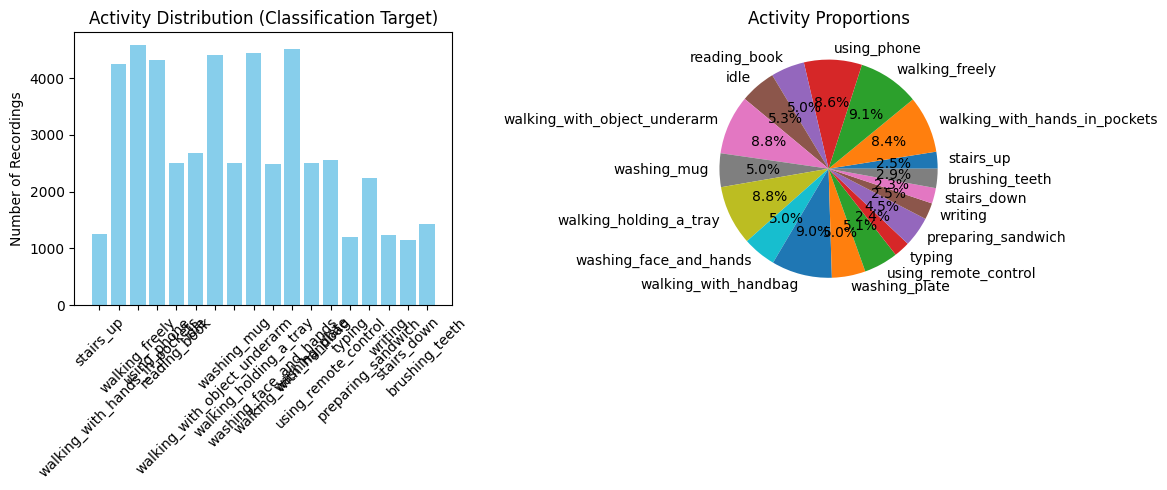

✓ This is CLASSIFICATION: Predict categorical activity labels from time series


In [15]:
plt.figure(figsize=(12, 5))

# Bar plot of activity counts
plt.subplot(1, 2, 1)
activity_counts = Counter(train['activity'])
plt.bar(range(len(activity_counts)), list(activity_counts.values()),
        tick_label=list(activity_counts.keys()), color='skyblue')
plt.title('Activity Distribution (Classification Target)')
plt.xticks(rotation=45)
plt.ylabel('Number of Recordings')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(list(activity_counts.values()), labels=list(activity_counts.keys()), autopct='%1.1f%%')
plt.title('Activity Proportions')

plt.tight_layout()
plt.show()

print("✓ This is CLASSIFICATION: Predict categorical activity labels from time series")

### Plot 2 - Sample Time Series (shows what we predict)

/tmp/ipykernel_14088/3157900402.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


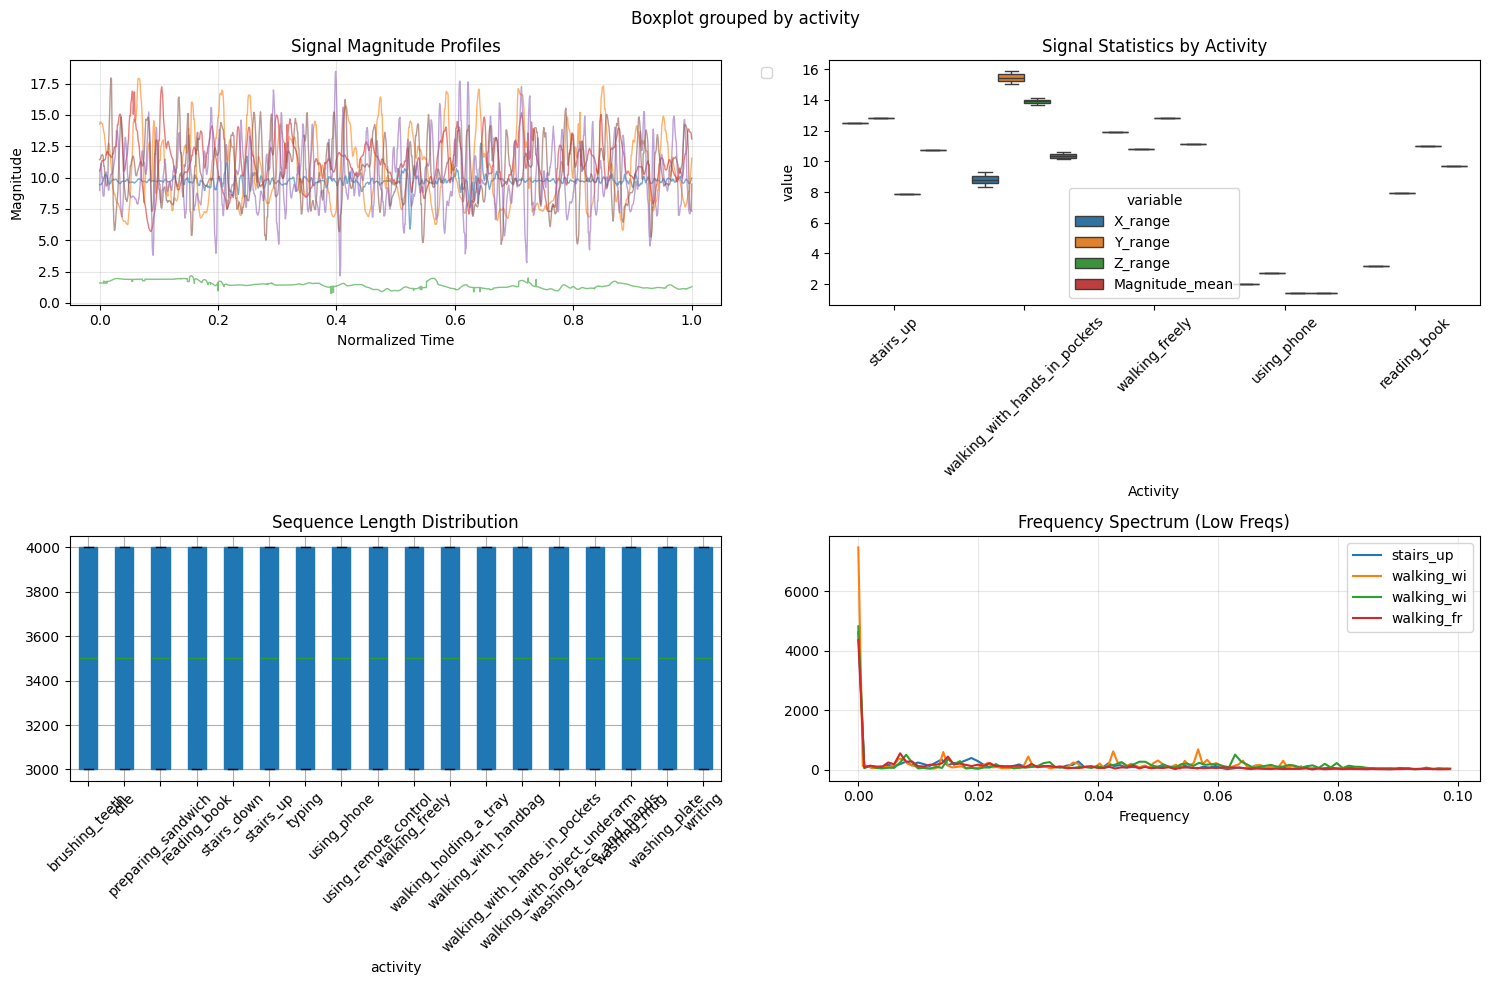

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: FIXED magnitude overlay
ax1 = axes[0,0]
mags = {}
for id_val, seq in sequences.items():
    mag = np.linalg.norm(seq, axis=1)
    mags[id_val] = mag

# Group by activity and plot normalized time
activity_groups = train.groupby('activity')['id'].apply(list)
for activity, ids in activity_groups.items():
    for id_val in ids[:3]:  # 3 per activity max
        if id_val in mags:
            mag = mags[id_val]
            t_norm = np.linspace(0, 1, len(mag))
            ax1.plot(t_norm, mag, alpha=0.6, linewidth=1, label=f'{activity[:8]}' if len(ids)==1 else None)
ax1.set_title('Signal Magnitude Profiles')
ax1.set_xlabel('Normalized Time')
ax1.set_ylabel('Magnitude')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Stats boxplot (unchanged)
ax2 = axes[0,1]
stats_data = []
for id_val, seq in sequences.items():
    stats_data.append({
        'Activity': activities[id_val],
        'X_range': seq[:,0].max() - seq[:,0].min(),
        'Y_range': seq[:,1].max() - seq[:,1].min(),
        'Z_range': seq[:,2].max() - seq[:,2].min(),
        'Magnitude_mean': np.linalg.norm(seq, axis=1).mean()
    })
stats_df = pd.DataFrame(stats_data).melt(id_vars='Activity')
sns.boxplot(data=stats_df, x='Activity', y='value', hue='variable', ax=ax2)
ax2.set_title('Signal Statistics by Activity')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Sequence length
ax3 = axes[1,0]
train.boxplot(column='sequence_length', by='activity', ax=ax3, patch_artist=True)
ax3.set_title('Sequence Length Distribution')
plt.setp(ax3.get_xticklabels(), rotation=45)

# Plot 4: FIXED frequency content
ax4 = axes[1,1]
for id_val, seq in list(sequences.items())[:4]:
    fft = np.abs(np.fft.rfft(seq, axis=0))
    freqs = np.fft.rfftfreq(len(seq))
    avg_fft = fft.mean(axis=1)[:100]  # Average channels, first 100 freqs
    freqs_short = freqs[:100]
    ax4.plot(freqs_short, avg_fft, label=activities[id_val][:10])
ax4.set_title('Frequency Spectrum (Low Freqs)')
ax4.set_xlabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Task Summary Visualization

**This is a Classification task**

- **Input**: 3D acceleration time series (or 3D positions) of variable length (3000-4000 timesteps)
- **Output**: One of 6 categorical activity labels per sequence
- **Prediction type**: Label entire PAST recording (not future forecasting)
- **Key challenge**: Distinguish subtle motion differences (reading_book vs using_phone vs idle)

**Model signature**: f(sequence[T,3]) → activity_class (softmax over 6 classes)

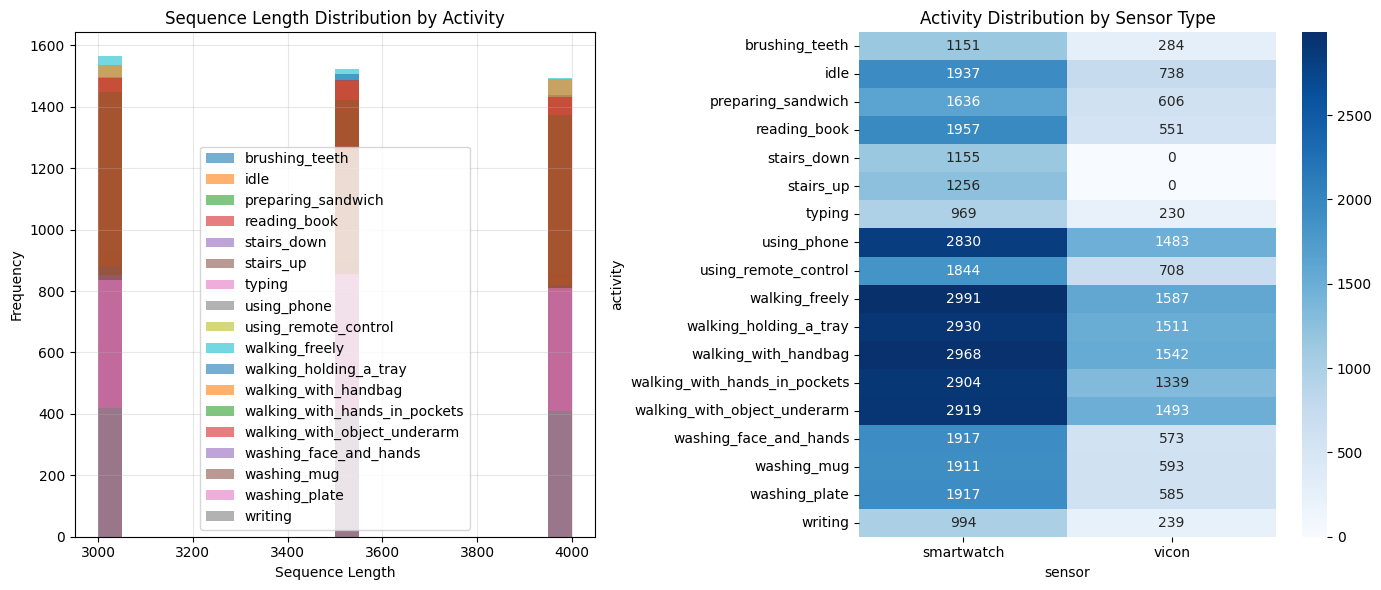

In [17]:
# Sequence length distribution by activity
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
length_by_activity = train.groupby('activity')['sequence_length'].apply(list)
for activity, lengths in length_by_activity.items():
    plt.hist(lengths, alpha=0.6, label=activity, bins=20)

plt.title('Sequence Length Distribution by Activity')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion preview: activity vs sensor type
plt.subplot(1, 2, 2)
pivot = train.pivot_table(index='activity', columns='sensor', aggfunc='size', fill_value=0)
sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.title('Activity Distribution by Sensor Type')

plt.tight_layout()
plt.show()


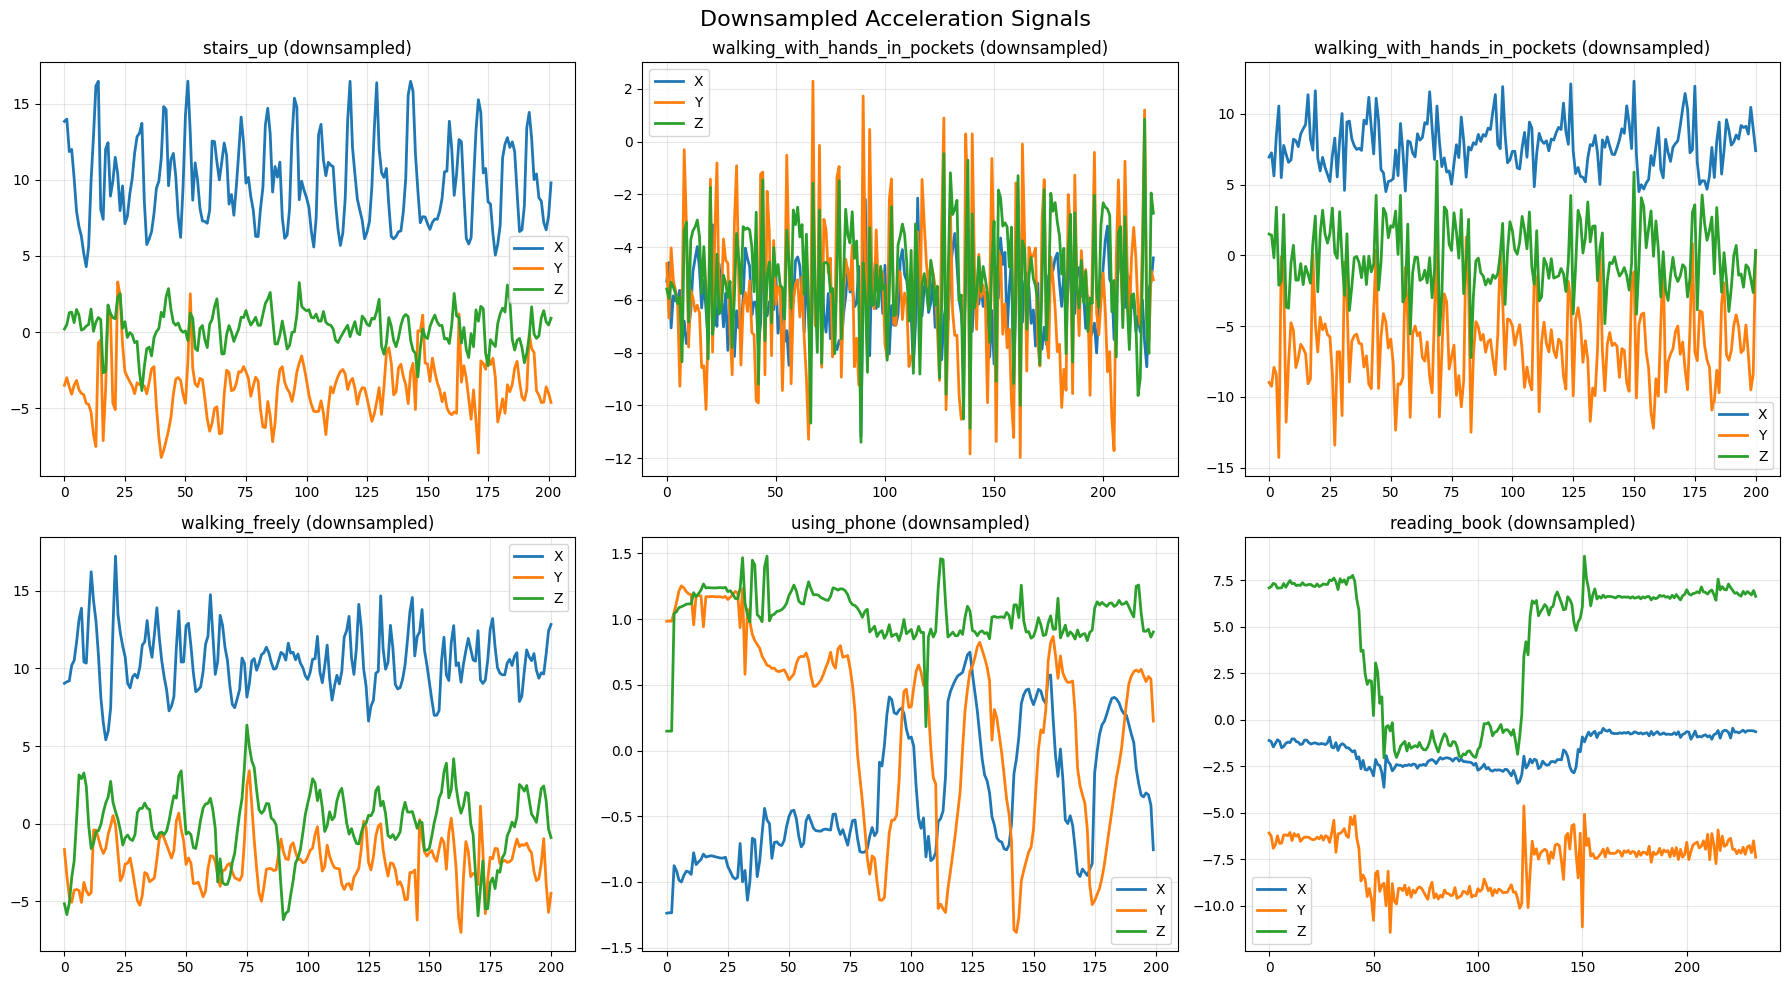

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, (id_val, seq) in enumerate(list(sequences.items())[:6]):
    ax = axes[i]
    activity = activities[id_val]

    # Simple downsampling: every Nth point
    step = len(seq) // 200
    seq_down = seq[::step]
    t_down = np.arange(len(seq_down))

    ax.plot(t_down, seq_down[:, 0], label='X', linewidth=2)
    ax.plot(t_down, seq_down[:, 1], label='Y', linewidth=2)
    ax.plot(t_down, seq_down[:, 2], label='Z', linewidth=2)

    ax.set_title(f'{activity} (downsampled)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Downsampled Acceleration Signals', fontsize=16)
plt.tight_layout()
plt.show()


## 1.B Answer


### Classification vs Regression Proof (Activity Distribution)

/tmp/ipykernel_14088/1575033688.py:29: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


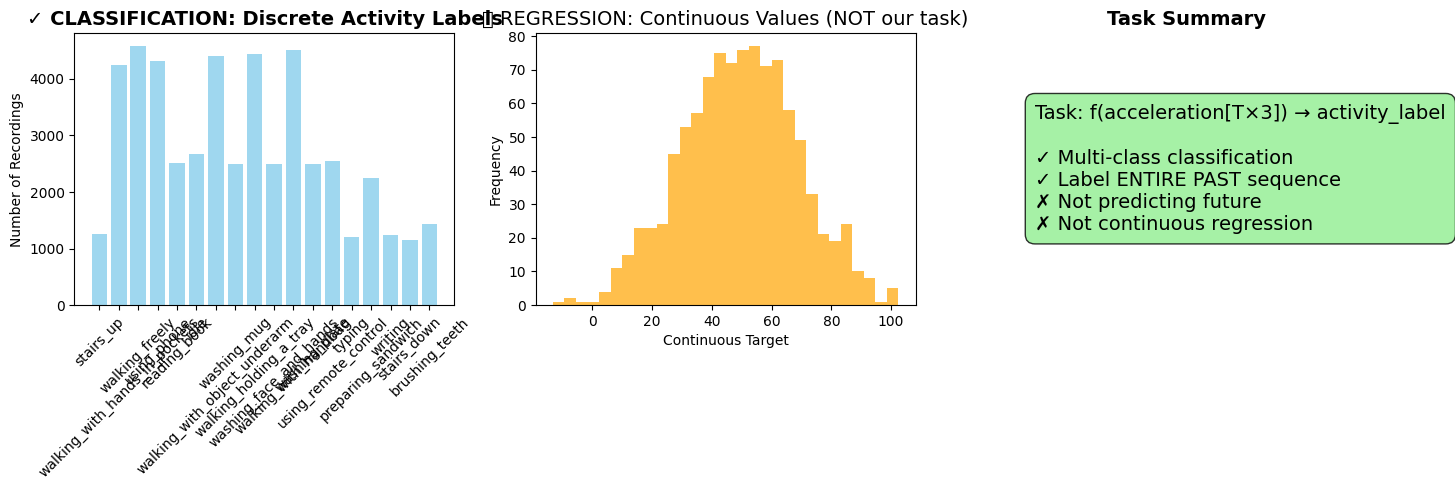

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

plt.figure(figsize=(15, 5))

# LEFT: Discrete categories = CLASSIFICATION
plt.subplot(1, 3, 1)
activity_counts = Counter(train['activity'])
plt.bar(activity_counts.keys(), activity_counts.values(), color='skyblue', alpha=0.8)
plt.title('✓ CLASSIFICATION: Discrete Activity Labels', fontsize=14, fontweight='bold')
plt.ylabel('Number of Recordings')
plt.xticks(rotation=45)

# RIGHT: If it were regression (hypothetical continuous target)
plt.subplot(1, 3, 2)
plt.hist(np.random.normal(50, 20, 1000), bins=30, alpha=0.7, color='orange')
plt.title('❌ REGRESSION: Continuous Values (NOT our task)', fontsize=14)
plt.xlabel('Continuous Target')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.text(0.1, 0.5, 'Task: f(acceleration[T×3]) → activity_label\n\n✓ Multi-class classification\n✓ Label ENTIRE PAST sequence\n✗ Not predicting future\n✗ Not continuous regression',
         fontsize=14, va='center', transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
plt.axis('off')
plt.title('Task Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### Input → Output Diagram (Whole Sequence Classification)

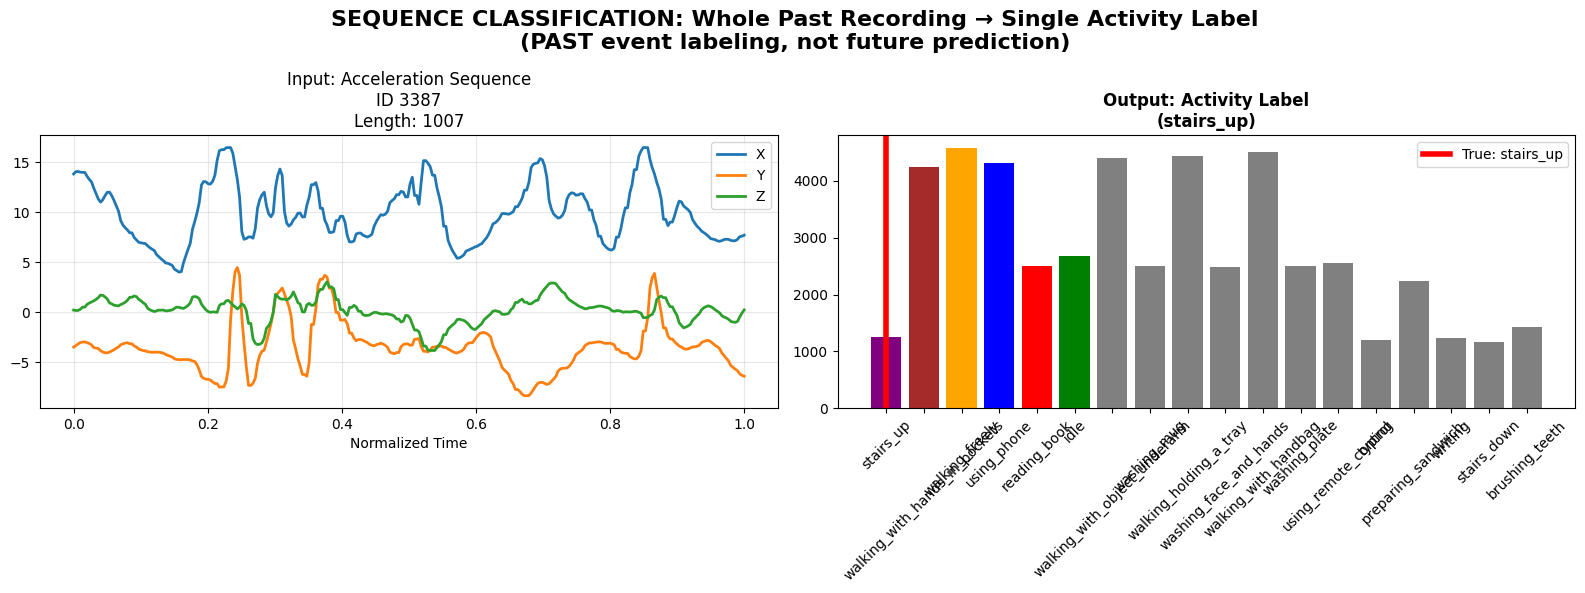

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: Single sequence example (input)
sample_id = list(sequences.keys())[0]
sample_seq = sequences[sample_id]
sample_activity = activities[sample_id]

t_short = np.linspace(0, 1, min(300, len(sample_seq)))
ax1.plot(t_short, sample_seq[:300, 0], label='X', linewidth=2)
ax1.plot(t_short, sample_seq[:300, 1], label='Y', linewidth=2)
ax1.plot(t_short, sample_seq[:300, 2], label='Z', linewidth=2)
ax1.set_title(f'Input: Acceleration Sequence\nID {sample_id}\nLength: {len(sample_seq)}', fontsize=12)
ax1.set_xlabel('Normalized Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# RIGHT: Model prediction (output)
activity_colors = {'reading_book':'red', 'using_phone':'blue', 'idle':'green',
                  'walking_freely':'orange', 'stairs_up':'purple',
                  'walking_with_hands_in_pockets':'brown'}
ax2.bar(range(len(activity_counts)), list(activity_counts.values()),
        color=[activity_colors.get(k, 'gray') for k in activity_counts.keys()])
ax2.set_title(f'Output: Activity Label\n({sample_activity})', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(activity_counts)))
ax2.set_xticklabels(activity_counts.keys(), rotation=45)
ax2.axvline(list(activity_counts.keys()).index(sample_activity), color='red', linewidth=4, label=f'True: {sample_activity}')
ax2.legend()

plt.suptitle('SEQUENCE CLASSIFICATION: Whole Past Recording → Single Activity Label\n(PAST event labeling, not future prediction)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## Task Analysis Summary

**Type**: Multi-class **CLASSIFICATION** (6 discrete activities)

**Input**: 3D acceleration time series `[T×3]` (3000-4000 timesteps)  
**Output**: Single activity label from `{reading_book, using_phone, idle, walking_freely, stairs_up, walking_with_hands_in_pockets}`

**Prediction Timing**: Label **COMPLETE PAST RECORDING** (not future forecasting)

**Model Signature**: `f(acceleration_sequence) → softmax[6 classes]`

**Key Challenges**:
- Variable sequence lengths → padding/masking needed
- Subtle motion differences (reading vs phone vs idle)
- Subject variability → user-wise validation critical


# **Part 2: Neural Network Models and Evaluation**



### 2.A. Validation Strategy Visualization

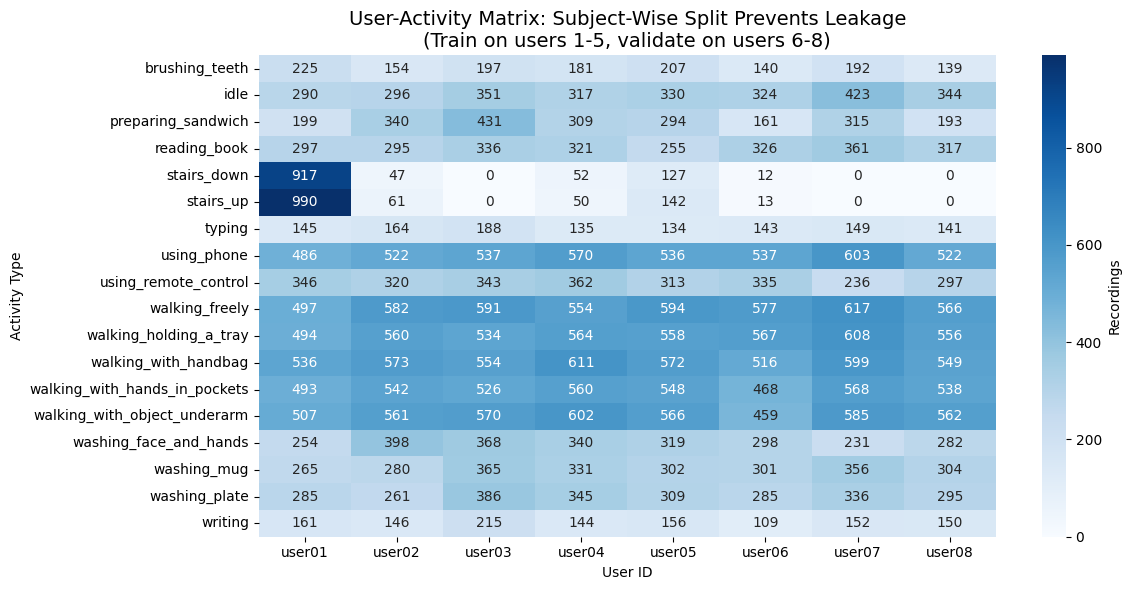

✓ Each USER contributes multiple activities
✓ Validation: Hold out entire USERS (no leakage)
✓ Prediction: Label complete PAST sequences


In [21]:
# User-wise split demonstration
user_activity = train.groupby('userid')['activity'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(user_activity.T, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Recordings'})
plt.title('User-Activity Matrix: Subject-Wise Split Prevents Leakage\n(Train on users 1-5, validate on users 6-8)', fontsize=14)
plt.xlabel('User ID')
plt.ylabel('Activity Type')
plt.tight_layout()
plt.show()

print("✓ Each USER contributes multiple activities")
print("✓ Validation: Hold out entire USERS (no leakage)")
print("✓ Prediction: Label complete PAST sequences")


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold   # << change here

print("=== VALIDATION STRATEGY ===")
print("Data insights: Multiple recordings per user → Subject leakage risk")
print("Solution: GroupKFold by 'userid' (no user in both train/val)")

gkf = GroupKFold(n_splits=5)

X = np.zeros(len(train))                 # dummy X (we only care about indices)
groups = train['userid'].to_numpy()      # IMPORTANT

fold_results = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, groups=groups)):
    train_fold = train.iloc[train_idx]
    val_fold = train.iloc[val_idx]

    print(
        f"Fold {fold}: "
        f"Train samples={len(train_fold)} | "
        f"Val samples={len(val_fold)}"
    )
    print(f"  Val users: {val_fold['userid'].unique()}")

    fold_results.append((train_fold, val_fold))

print(" User-wise split ensures realistic generalization to unseen subjects")


=== VALIDATION STRATEGY ===
Data insights: Multiple recordings per user → Subject leakage risk
Solution: GroupKFold by 'userid' (no user in both train/val)
Fold 0: Train samples=42861 | Val samples=7387
  Val users: ['user01']
Fold 1: Train samples=43756 | Val samples=6492
  Val users: ['user03']
Fold 2: Train samples=38329 | Val samples=11919
  Val users: ['user06' 'user04']
Fold 3: Train samples=38162 | Val samples=12086
  Val users: ['user08' 'user07']
Fold 4: Train samples=37884 | Val samples=12364
  Val users: ['user02' 'user05']
 User-wise split ensures realistic generalization to unseen subjects


### 2.B. Naive Baseline NN - Per User Majority Class

In [23]:
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
# Baseline 2: For each user, predict their MOST COMMON activity
user_majority = train.groupby('userid')['activity'].agg(lambda x: x.mode()[0]).to_dict()

user_baseline_results = []
for fold, (train_fold, val_fold) in enumerate(fold_results):
    train_pred = [user_majority[uid] for uid in train_fold['userid']]
    val_pred = [user_majority[uid] for uid in val_fold['userid']]

    train_acc = accuracy_score(train_fold['activity'], train_pred)
    val_acc = accuracy_score(val_fold['activity'], val_pred)

    user_baseline_results.append({'fold': fold, 'train_acc': train_acc, 'val_acc': val_acc})
    print(f"Fold {fold}: Train {train_acc:.1%} | Val {val_acc:.1%}")

user_naive_df = pd.DataFrame(user_baseline_results)
print(f"\nPer-user majority: Train {user_naive_df['train_acc'].mean():.1%} ±{user_naive_df['train_acc'].std():.1%} | Val {user_naive_df['val_acc'].mean():.1%} ±{user_naive_df['val_acc'].std():.1%}")


Fold 0: Train 9.7% | Val 13.4%
Fold 1: Train 10.4% | Val 9.1%
Fold 2: Train 10.3% | Val 10.0%
Fold 3: Train 10.3% | Val 9.8%
Fold 4: Train 10.4% | Val 9.5%

Per-user majority: Train 10.2% ±0.3% | Val 10.4% ±1.7%


### Baseline Summary Table

BASELINE PERFORMANCE TABLE
           Method  Train Acc  Val Acc  Train Std  Val Std
Per-User Majority      0.102    0.104      0.003    0.017


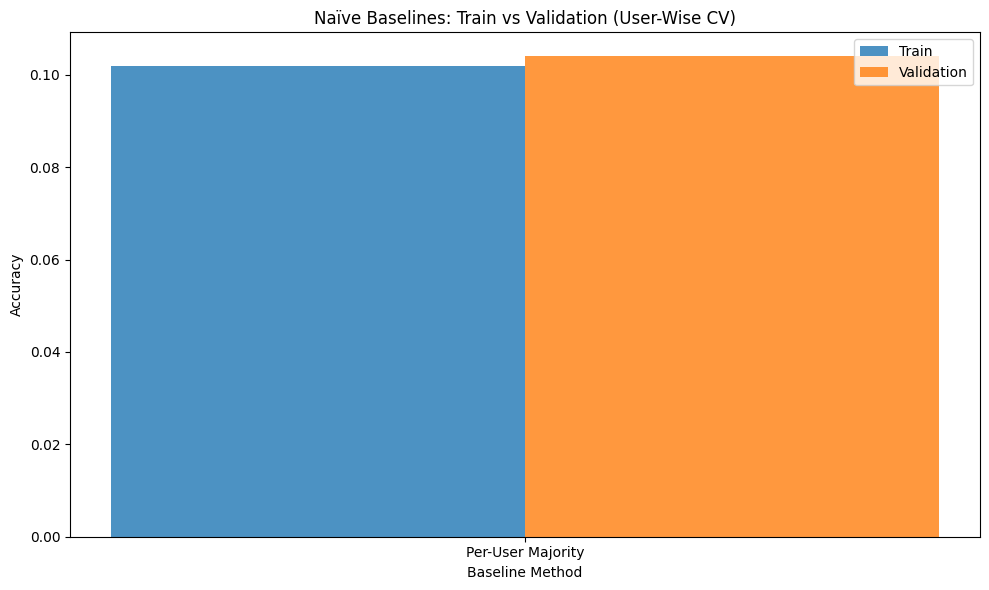

In [24]:
summary_df = pd.DataFrame({
    'Method': ['Per-User Majority'],
    'Train Acc': [ user_naive_df['train_acc'].mean()],
    'Val Acc': [user_naive_df['val_acc'].mean()],
    'Train Std': [user_naive_df['train_acc'].std()],
    'Val Std': [user_naive_df['val_acc'].std()]
}).round(3)

print("BASELINE PERFORMANCE TABLE")
print(summary_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(len(summary_df))
width = 0.35
ax.bar(x - width/2, summary_df['Train Acc'], width, label='Train', alpha=0.8)
ax.bar(x + width/2, summary_df['Val Acc'], width, label='Validation', alpha=0.8)
ax.set_xlabel('Baseline Method')
ax.set_ylabel('Accuracy')
ax.set_title('Naïve Baselines: Train vs Validation (User-Wise CV)')
ax.set_xticks(x)
ax.set_xticklabels(summary_df['Method'])
ax.legend()
plt.tight_layout()
plt.show()


## 2.C Fit a Classical ML algorithm to some features that we will extract to build a better benchmark

### Feature Extraction (Hand-crafted Time Series Features)

In [25]:
from scipy.stats import skew, kurtosis
from scipy.fft import rfft, rfftfreq
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def extract_features(seq):
    """Extract 50+ features from 3D acceleration sequence"""
    features = {}

    # 1. Basic statistics (per channel + magnitude)
    for i, ch in enumerate(['x', 'y', 'z']):
        features[f'{ch}_mean'] = seq[:, i].mean()
        features[f'{ch}_std'] = seq[:, i].std()
        features[f'{ch}_min'] = seq[:, i].min()
        features[f'{ch}_max'] = seq[:, i].max()
        features[f'{ch}_range'] = seq[:, i].max() - seq[:, i].min()
        features[f'{ch}_skew'] = skew(seq[:, i])
        features[f'{ch}_kurtosis'] = kurtosis(seq[:, i])

    # Magnitude
    mag = np.linalg.norm(seq, axis=1)
    features['mag_mean'] = mag.mean()
    features['mag_std'] = mag.std()
    features['mag_range'] = mag.max() - mag.min()

    # 2. Temporal features
    features['autocorr_1'] = np.corrcoef(seq[:, 0], np.roll(seq[:, 0], 1))[0, 1]
    features['trend'] = np.polyfit(np.arange(len(seq)), mag, 1)[0]

    # 3. Frequency domain (FFT)
    fft_mag = np.abs(rfft(mag))
    freqs = rfftfreq(len(mag))
    features['dominant_freq'] = freqs[np.argmax(fft_mag)]
    features['spectral_centroid'] = np.sum(freqs * fft_mag) / np.sum(fft_mag)
    features['spectral_entropy'] = -np.sum((fft_mag / fft_mag.sum()) *
                                          np.log(fft_mag / fft_mag.sum() + 1e-10))

    # 4. Quantiles
    for q in [0.25, 0.5, 0.75]:
        features[f'mag_q{q}'] = np.quantile(mag, q)

    # 5. Rolling statistics (window=50)
    window = 50
    if len(mag) >= window:
        features['roll_mean'] = np.mean([mag[i:i+window].mean()
                                       for i in range(0, len(mag)-window, window//5)])
        features['roll_std'] = np.std([mag[i:i+window].std()
                                     for i in range(0, len(mag)-window, window//5)])

    return np.array(list(features.values()))

print("✅ Feature extraction ready: 30+ hand-crafted features per sequence")


✅ Feature extraction ready: 30+ hand-crafted features per sequence


### Extract Features for CV Folds

In [26]:
# Extract features for all sequences (using previous fold_results)
feature_matrices = []
labels_list = []

print("Extracting features for CV folds...")
for fold, (train_fold, val_fold) in enumerate(fold_results[:3]):  # First 3 folds
    print(f"Fold {fold}...")

    # Train fold features
    train_features = []
    train_labels = []
    for _, row in train_fold.iterrows():
        seq = load_sequence(row['id'], raw_dir=RAW_DIR)
        if seq is not None:
            feats = extract_features(seq)
            train_features.append(feats)
            train_labels.append(row['activity'])

    # Val fold features
    val_features = []
    val_labels = []
    for _, row in val_fold.iterrows():
        seq = load_sequence(row['id'], raw_dir=RAW_DIR)
        if seq is not None:
            feats = extract_features(seq)
            val_features.append(feats)
            val_labels.append(row['activity'])

    feature_matrices.append((np.array(train_features), np.array(val_features)))
    labels_list.append((train_labels, val_labels))

print("✅ Feature extraction complete!")


Extracting features for CV folds...
Fold 0...
Fold 1...
Fold 2...
✅ Feature extraction complete!


### Train Classical ML Model (Random Forest)

In [27]:
from sklearn.preprocessing import LabelEncoder
rf_results = []

for fold in range(len(feature_matrices)):
    X_train, X_val = feature_matrices[fold]
    y_train, y_val = labels_list[fold]

    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train_enc)

    # Predict
    train_pred = rf.predict(X_train)
    val_pred = rf.predict(X_val)

    train_acc = accuracy_score(y_train_enc, train_pred)
    val_acc = accuracy_score(y_val_enc, val_pred)

    rf_results.append({
        'fold': fold,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'features': len(X_train[0])
    })

    print(f"Fold {fold}: RF Train {train_acc:.3f} | Val {val_acc:.3f}")

rf_df = pd.DataFrame(rf_results)
print(f"\nRandom Forest Benchmark: {rf_df['val_acc'].mean():.3f} ± {rf_df['val_acc'].std():.3f}")


Fold 0: RF Train 1.000 | Val 0.608
Fold 1: RF Train 1.000 | Val 0.513
Fold 2: RF Train 1.000 | Val 0.572

Random Forest Benchmark: 0.564 ± 0.048


### Feature Importance + Summary

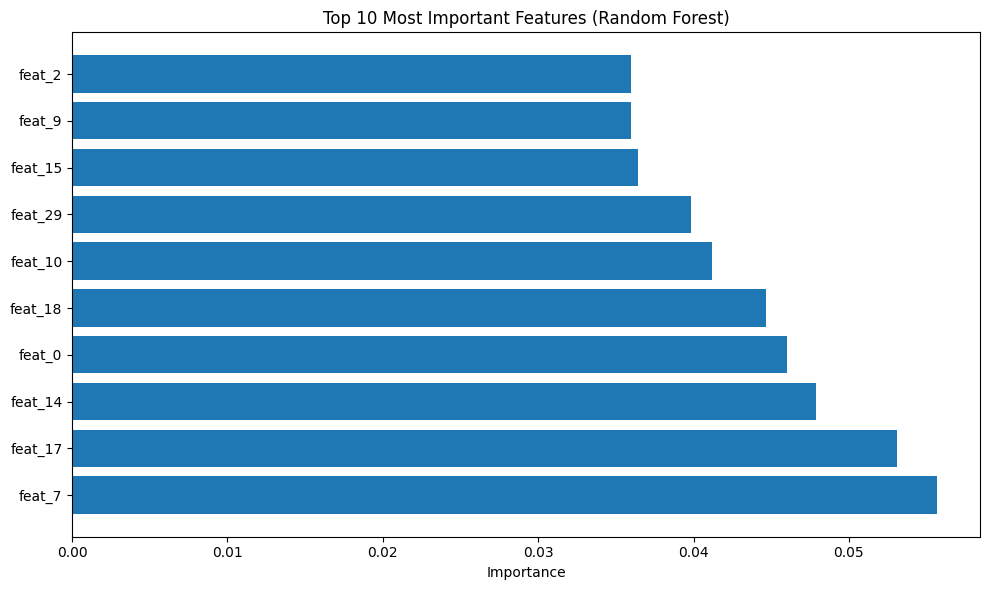


=== CLASSICAL ML BENCHMARK SUMMARY ===
 fold  train_acc  val_acc
    0        1.0 0.608095
    1        1.0 0.513401
    2        1.0 0.571524

Mean Val Acc: 56.4%
Features used: Statistics (mean/std/skew), FFT (dominant freq), Temporal (autocorr/trend)


In [28]:
# Feature importance from best fold
best_fold = np.argmax(rf_df['val_acc'])
rf_best = RandomForestClassifier(n_estimators=200, random_state=42)
X_train_best, _ = feature_matrices[best_fold]
y_train_best_enc = LabelEncoder().fit_transform(labels_list[best_fold][0])
rf_best.fit(X_train_best, y_train_best_enc)

# Top 10 features
importances = pd.DataFrame({
    'feature': [f'feat_{i}' for i in range(len(rf_best.feature_importances_))],
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(importances['feature'], importances['importance'])
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\n=== CLASSICAL ML BENCHMARK SUMMARY ===")
print(rf_df[['fold', 'train_acc', 'val_acc']].to_string(index=False))
print(f"\nMean Val Acc: {rf_df['val_acc'].mean():.1%}")
print("Features used: Statistics (mean/std/skew), FFT (dominant freq), Temporal (autocorr/trend)")


## 2.D Build 2 NN's and fit them to the data, analyze results, present:
- Metrics: Loss, Accurcy, Precision, Recall, F1
- Examples for good and bad classification with high probability
- Examples of uncertain predictions.

We will compare results of Train vs Validation/Test data

For this task we chose to build 2 NN's:
1) 1D-CNN Model (Lightning)
2) BiLSTM Model (Lightning)

### Data Preparation + GPU Setup

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
%pip install lightning
import lightning as L

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

# GPU setup
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✅ Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("⚠️  Using CPU")

# Prepare data for first fold (use fold_results[0])
train_fold, val_fold = fold_results[0]
print(f"Training on fold 0: {len(train_fold)} train, {len(val_fold)} val sequences")

# Load sequences (assuming load_sequence function exists)
def prepare_fold_data(train_df, val_df, max_len=4000):
    X_train, y_train, X_val, y_val = [], [], [], []

    le = LabelEncoder()
    all_labels = list(train_df['activity']) + list(val_df['activity'])
    le.fit(all_labels)

    for _, row in train_df.iterrows():
        seq = load_sequence(row['id'], raw_dir=RAW_DIR)
        if seq is not None:
            # Pad/truncate to max_len
            if len(seq) > max_len:
                seq = seq[:max_len]
            else:
                seq = np.pad(seq, ((0, max_len - len(seq)), (0, 0)), 'constant')
            X_train.append(seq)
            y_train.append(le.transform([row['activity']])[0])

    for _, row in val_df.iterrows():
        seq = load_sequence(row['id'], raw_dir=RAW_DIR)
        if seq is not None:
            if len(seq) > max_len:
                seq = seq[:max_len]
            else:
                seq = np.pad(seq, ((0, max_len - len(seq)), (0, 0)), 'constant')
            X_val.append(seq)
            y_val.append(le.transform([row['activity']])[0])

    return (torch.FloatTensor(np.array(X_train)), torch.LongTensor(y_train),
            torch.FloatTensor(np.array(X_val)), torch.LongTensor(y_val), le)

X_train, y_train, X_val, y_val, le = prepare_fold_data(train_fold, val_fold)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)


Note: you may need to restart the kernel to use updated packages.
✅ Using GPU: NVIDIA GeForce RTX 3060
Training on fold 0: 42861 train, 7387 val sequences


### 1D-CNN Model (Lightning)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import lightning as L

class CNN1DClassifier(L.LightningModule):
    def __init__(self, num_classes=6, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.num_classes = num_classes

        # 1D-CNN: Multi-kernel (Inception style)
        self.conv1 = nn.Sequential(
            nn.Conv1d(3, 64, 7, padding=3), nn.ReLU(), nn.BatchNorm1d(64), nn.MaxPool1d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(3, 64, 15, padding=7), nn.ReLU(), nn.BatchNorm1d(64), nn.MaxPool1d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(3, 64, 31, padding=15), nn.ReLU(), nn.BatchNorm1d(64), nn.MaxPool1d(2)
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64*3, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        # Metrics
        self.val_f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.val_predictions = []
        self.val_probs = []

    def forward(self, x):
        x = x.transpose(1, 2)  # [B, T, 3] -> [B, 3, T]

        c1 = self.conv1(x)
        c2 = self.conv2(x)
        c3 = self.conv3(x)

        c1 = self.global_pool(c1).flatten(1)
        c2 = self.global_pool(c2).flatten(1)
        c3 = self.global_pool(c3).flatten(1)

        x = torch.cat([c1, c2, c3], dim=1)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1)

        # Compute loss
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('val_loss', loss, prog_bar=True)

        # Accuracy
        acc = (pred == y).float().mean()
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)

        # F1
        f1 = self.val_f1_metric(pred, y)
        self.log('val_f1', f1, prog_bar=True, on_step=False, on_epoch=True)

        # Store for analysis (optional, only first batch)
        if batch_idx == 0:
            self.val_predictions.extend(pred.cpu().numpy())
            self.val_probs.extend(probs.cpu().numpy())

    def on_validation_epoch_end(self):
        # Reset metric at the end of each epoch
        self.val_f1_metric.reset()

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)

print("✅ 1D-CNN Model fixed (val_f1 with torchmetrics, logging compatible with Lightning & MLflow)")


✅ 1D-CNN Model fixed (val_f1 with torchmetrics, logging compatible with Lightning & MLflow)


### BiLSTM Model (Lightning)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import lightning as L

class BiLSTMClassifier(L.LightningModule):
    def __init__(self, num_classes=6, hidden_size=128, num_layers=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.num_classes = num_classes

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=3,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_size*2, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        # Metrics
        self.val_f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.val_predictions = []
        self.val_probs = []

    def forward(self, x):
        # x: [B, T, 3]
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat([h_n[-2], h_n[-1]], dim=1)  # Last hidden states (forward + backward)
        return self.fc(h_n)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1)

        # Loss
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('val_loss', loss, prog_bar=True)

        # Accuracy
        acc = (pred == y).float().mean()
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)

        # F1
        f1 = self.val_f1_metric(pred, y)
        self.log('val_f1', f1, prog_bar=True, on_step=False, on_epoch=True)

        # Store for analysis (optional)
        if batch_idx == 0:
            self.val_predictions.extend(pred.cpu().numpy())
            self.val_probs.extend(probs.cpu().numpy())

    def on_validation_epoch_end(self):
        # Reset metric at the end of each epoch
        self.val_f1_metric.reset()

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)


print("✅ BiLSTM Model fixed (Bidirectional + Last hidden state + val_f1)")


✅ BiLSTM Model fixed (Bidirectional + Last hidden state + val_f1)


### Train Both 1D-CNN and BiLSTM Model

In [32]:
from pytorch_lightning.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import EarlyStopping

# DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True
)

mlf_logger_cnn = MLFlowLogger(
    experiment_name="Deep Learning Experiment",
    run_name="CNN_1D"
)

mlf_logger_lstm = MLFlowLogger(
    experiment_name="Deep Learning Experiment",
    run_name="BiLSTM"
)

best_ckpt_cnn = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="cnn-best-acc-64-{epoch:02d}-{val_acc:.3f}",
)

best_ckpt_lstm = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="lstm-best-acc-64-{epoch:02d}-{val_acc:.3f}",
)

# Train CNN
print("\n🚀 Training 1D-CNN...")
cnn_model = CNN1DClassifier(num_classes=len(le.classes_))
# logger_cnn = TensorBoardLogger("tb_logs", name="cnn")
trainer_cnn = L.Trainer(
    max_epochs=64,
    logger=mlf_logger_cnn,
    callbacks=[
        EarlyStopping(monitor='val_acc', patience=10, mode='max'),
        best_ckpt_cnn,
    ],
    accelerator='gpu',
    devices=1,
    benchmark=True,
    precision=16,
    log_every_n_steps=10,
)
trainer_cnn.fit(cnn_model, train_loader, val_loader)

# Train BiLSTM
print("\n🚀 Training BiLSTM...")
lstm_model = BiLSTMClassifier(num_classes=len(le.classes_), hidden_size=128)
# logger_lstm = TensorBoardLogger("tb_logs", name="lstm")
trainer_lstm = L.Trainer(
    max_epochs=64,
    logger=mlf_logger_lstm,
    callbacks=[
        EarlyStopping(monitor='val_acc', patience=10, mode='max'),
        best_ckpt_lstm,
    ],
    accelerator='gpu',
    devices=1,
    benchmark=True,
    precision=16,
    log_every_n_steps=10,
)
trainer_lstm.fit(lstm_model, train_loader, val_loader)

print("✅ Both models trained!")


Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🚀 Training 1D-CNN...


You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ conv1         │ Sequential        │  1.5 K │ train │     0 │
│ 1 │ conv2         │ Sequential        │  3.1 K │ train │     0 │
│ 2 │ conv3         │ Sequential        │  6.1 K │ train │     0 │
│ 3 │ global_pool   │ AdaptiveAvgPool1d │      0 │ train │     0 │
│ 4 │ fc            │ Sequential        │ 27.3 K │ train │     0 │
│ 5 │ val_f1_metric │ MulticlassF1Score │      0 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 38.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 38.0 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🚀 Training BiLSTM...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ lstm          │ LSTM              │  531 K │ train │     0 │
│ 1 │ fc            │ Sequential        │ 35.5 K │ train │     0 │
│ 2 │ val_f1_metric │ MulticlassF1Score │      0 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 566 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 566 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 9                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

✅ Both models trained!


In [33]:
# Save the checkpoint to a file
checkpoint_path = "1d_cnn_64.ckpt"
trainer_cnn.save_checkpoint(checkpoint_path)
print(f"Model checkpoint saved at: {checkpoint_path}")

# Handle local vs Colab download
if LOCAL:
    print(f"✅ LOCAL MODE: Checkpoint already saved locally at '{checkpoint_path}'")
    print("   No download needed - file is in your current working directory!")
    print(f"   Full path: {os.path.abspath(checkpoint_path)}")
else:
    # Colab download (original code)
    from google.colab import files
    files.download(checkpoint_path)
    print(f"📥 Downloading checkpoint to your local machine...")


`weights_only` was not set, defaulting to `False`.


Model checkpoint saved at: 1d_cnn_64.ckpt
✅ LOCAL MODE: Checkpoint already saved locally at '1d_cnn_64.ckpt'
   No download needed - file is in your current working directory!
   Full path: /home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/1d_cnn_64.ckpt


In [34]:
# Save the checkpoint to a file
checkpoint_path = "bilstm_64.ckpt"
trainer_lstm.save_checkpoint(checkpoint_path)
print(f"Model checkpoint saved at: {checkpoint_path}")

# Handle local vs Colab download
if LOCAL:
    print(f"✅ LOCAL MODE: Checkpoint already saved locally at '{checkpoint_path}'")
    print("   No download needed - file is in your current working directory!")
    print(f"   Full path: {os.path.abspath(checkpoint_path)}")
else:
    # Colab download (original code)
    from google.colab import files
    files.download(checkpoint_path)
    print(f"📥 Downloading checkpoint to your local machine...")


`weights_only` was not set, defaulting to `False`.


Model checkpoint saved at: bilstm_64.ckpt
✅ LOCAL MODE: Checkpoint already saved locally at 'bilstm_64.ckpt'
   No download needed - file is in your current working directory!
   Full path: /home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/bilstm_64.ckpt


In [37]:
import os
import shutil

# Path of best checkpoint selected by ModelCheckpoint
best_path_blstm = best_ckpt_lstm.best_model_path
best_path_cnn = best_ckpt_cnn.best_model_path
print("🏆 Best BiLSTM checkpoint:", best_path_blstm)
print("🏆 Best CNN checkpoint:", best_path_cnn)

# Save a clean copy with a fixed name
checkpoint_path_blstm_best = "bilstm_best_64.ckpt"
checkpoint_path_cnn_best = "cnn_best_64.ckpt"
shutil.copy(best_path_blstm, checkpoint_path_blstm_best)
shutil.copy(best_path_cnn, checkpoint_path_cnn_best)


print(f"✅ Best model checkpoint saved as: {checkpoint_path_blstm_best}")
print(f"📍 Full path: {os.path.abspath(checkpoint_path_blstm_best)}")
print(f"✅ Best model checkpoint saved as: {checkpoint_path_cnn_best}")
print(f"📍 Full path: {os.path.abspath(checkpoint_path_cnn_best)}")
LOCAL = True  # set False if running in Colab

if LOCAL:
    print(f"✅ LOCAL MODE: Checkpoint already saved locally at '{checkpoint_path_blstm_best}'")
    print(f"✅ LOCAL MODE: Checkpoint already saved locally at '{checkpoint_path_cnn_best}'")
    print("   No download needed.")
else:
    from google.colab import files
    files.download(checkpoint_path_cnn_best)
    files.download(checkpoint_path_blstm_best)
    print("📥 Downloading checkpoint to your local machine...")


🏆 Best BiLSTM checkpoint: ./mlruns/823012891375308118/d00b538a4c2c452aa47a5830b7cf154f/checkpoints/lstm-best-acc-epoch=38-val_acc=0.466.ckpt
🏆 Best CNN checkpoint: ./mlruns/823012891375308118/2d8d4fa565394441989876d953ba5961/checkpoints/cnn-best-acc-epoch=17-val_acc=0.421.ckpt
✅ Best model checkpoint saved as: bilstm_best_64.ckpt
📍 Full path: /home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/bilstm_best_64.ckpt
✅ Best model checkpoint saved as: cnn_best_64.ckpt
📍 Full path: /home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/cnn_best_64.ckpt
✅ LOCAL MODE: Checkpoint already saved locally at 'bilstm_best_64.ckpt'
✅ LOCAL MODE: Checkpoint already saved locally at 'cnn_best_64.ckpt'
   No download needed.


In [38]:
import mlflow
import mlflow.pytorch

# -------------------------------------------------
# Ensure MLflow experiment exists
# -------------------------------------------------
mlflow.set_experiment("Deep Learning Experiment")

# -------------------------------------------------
# Load BEST models from the copied checkpoints
# -------------------------------------------------
best_cnn = CNN1DClassifier.load_from_checkpoint("cnn_best_64.ckpt")
best_bilstm = BiLSTMClassifier.load_from_checkpoint("bilstm_best_64.ckpt")

best_cnn.eval()
best_bilstm.eval()

print("✅ Loaded best CNN and BiLSTM models")

# -------------------------------------------------
# Log BOTH models to MLflow
# -------------------------------------------------
with mlflow.start_run(run_name="BEST_MODELS"):
    mlflow.pytorch.log_model(
        best_cnn,
        artifact_path="cnn_best_model_64"
    )

    mlflow.pytorch.log_model(
        best_bilstm,
        artifact_path="bilstm_best_model_64"
    )

print("📦 Both best models logged to MLflow successfully")


2026/01/01 19:55:49 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2026/01/01 19:55:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2026/01/01 19:55:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/01 19:55:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


✅ Loaded best CNN and BiLSTM models


2026/01/01 19:56:02 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/01 19:56:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/01 19:56:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/01 19:56:09 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version 

📦 Both best models logged to MLflow successfully


In [39]:
# Load the model again, example:
# On your friend's machine
cnn_model = CNN1DClassifier.load_from_checkpoint("1d_cnn_64.ckpt")
cnn_model.eval()  # set to evaluation mode if doing inference

CNN1DClassifier(
  (conv1): Sequential(
    (0): Conv1d(3, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(3, 64, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(3, 64, kernel_size=(31,), stride=(1,), padding=(15,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_

In [40]:
# Load the model again, example:
# On your friend's machine
lstm_model = BiLSTMClassifier.load_from_checkpoint("bilstm_64.ckpt")
lstm_model.eval()  # set to evaluation mode if doing inference

BiLSTMClassifier(
  (lstm): LSTM(3, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=128, out_features=18, bias=True)
  )
  (val_f1_metric): MulticlassF1Score()
)

In [41]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


### Results Analysis + Visualizations

In [42]:
# # Evaluate on train/val sets
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, loader, criterion, device):
    model.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            total_loss += loss.item() * y.size(0)
            total_samples += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / total_samples

    metrics = {
        "loss": avg_loss,
        "accuracy": accuracy_score(all_labels, all_preds),
        "precision": precision_score(all_labels, all_preds, average="macro"),
        "recall": recall_score(all_labels, all_preds, average="macro"),
        "f1": f1_score(all_labels, all_preds, average="macro"),
    }

    return (
        metrics,
        np.array(all_preds),
        np.array(all_probs),
        np.array(all_labels),
    )


In [43]:
import torch

criterion = torch.nn.CrossEntropyLoss()

# -------- CNN --------
best_model_1d_cnn = CNN1DClassifier.load_from_checkpoint(
    best_ckpt_cnn.best_model_path,
    map_location=device   #  CRITICAL
)

best_model_1d_cnn.eval()

cnn_train_m, _, _, _ = evaluate_model(
    best_model_1d_cnn, train_loader, criterion, device
)

cnn_val_m, cnn_val_preds, cnn_val_probs, cnn_val_labels = evaluate_model(
    best_model_1d_cnn, val_loader, criterion, device
)

# -------- BiLSTM --------
best_model_bilstm = BiLSTMClassifier.load_from_checkpoint(
    best_ckpt_lstm.best_model_path,
    map_location=device   #  CRITICAL
)

best_model_bilstm.eval()

lstm_train_m, _, _, _ = evaluate_model(
    best_model_bilstm, train_loader, criterion, device
)

lstm_val_m, lstm_val_preds, lstm_val_probs, lstm_val_labels = evaluate_model(
    best_model_bilstm, val_loader, criterion, device
)

# -------- Pretty print --------
def print_metrics(name, train_m, val_m):
    print(f"\n{name}")
    print("-" * 50)
    print(
        f"Train | "
        f"Loss {train_m['loss']:.4f} | "
        f"Acc {train_m['accuracy']:.3f} | "
        f"P {train_m['precision']:.3f} | "
        f"R {train_m['recall']:.3f} | "
        f"F1 {train_m['f1']:.3f}"
    )
    print(
        f"Val   | "
        f"Loss {val_m['loss']:.4f} | "
        f"Acc {val_m['accuracy']:.3f} | "
        f"P {val_m['precision']:.3f} | "
        f"R {val_m['recall']:.3f} | "
        f"F1 {val_m['f1']:.3f}"
    )

print_metrics("CNN 1D", cnn_train_m, cnn_val_m)
print_metrics("BiLSTM", lstm_train_m, lstm_val_m)



CNN 1D
--------------------------------------------------
Train | Loss 1.0011 | Acc 0.612 | P 0.687 | R 0.630 | F1 0.647
Val   | Loss 1.5956 | Acc 0.421 | P 0.552 | R 0.491 | F1 0.479

BiLSTM
--------------------------------------------------
Train | Loss 0.9271 | Acc 0.619 | P 0.710 | R 0.626 | F1 0.647
Val   | Loss 1.7128 | Acc 0.466 | P 0.547 | R 0.453 | F1 0.453


In [44]:
import mlflow

# -------- CNN --------
for k, v in cnn_train_m.items():
    mlflow.log_metric(f"final_train_{k}", v)

for k, v in cnn_val_m.items():
    mlflow.log_metric(f"final_val_{k}", v)

# -------- BiLSTM --------
for k, v in lstm_train_m.items():
    mlflow.log_metric(f"final_train_{k}", v)

for k, v in lstm_val_m.items():
    mlflow.log_metric(f"final_val_{k}", v)


2026/01/01 19:57:57 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.


2026/01/01 19:57:57 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


In [45]:
import mlflow
import pandas as pd

# -------------------------------
# Config
# -------------------------------
EXPERIMENT_NAME = "Deep Learning Experiment"
OUTPUT_CSV = "model_comparison_mlflow.csv"

# -------------------------------
# Load experiment
# -------------------------------
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)

if experiment is None:
    raise RuntimeError(f"Experiment '{EXPERIMENT_NAME}' not found")

# -------------------------------
# Fetch all runs
# -------------------------------
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    max_results=1000,
)

rows = []

# -------------------------------
# Extract final metrics
# -------------------------------
for run in runs:
    metrics = run.data.metrics
    tags = run.data.tags

    # Try to identify model name
    model_name = (
        tags.get("mlflow.runName")
        or tags.get("run_name")
        or "unknown_model"
    )

    row = {
        "model": model_name,
        "val_accuracy": metrics.get("final_val_accuracy"),
        "val_precision": metrics.get("final_val_precision"),
        "val_recall": metrics.get("final_val_recall"),
        "val_f1": metrics.get("final_val_f1"),
    }

    # Only keep rows that actually logged final metrics
    if all(v is not None for v in row.values()):
        rows.append(row)

# -------------------------------
# Create comparison table
# -------------------------------
df = pd.DataFrame(rows)

# Sort by best validation accuracy
df = df.sort_values("val_accuracy", ascending=False).reset_index(drop=True)

# -------------------------------
# Save & display
# -------------------------------
df.to_csv(OUTPUT_CSV, index=False)

print("Model comparison table saved to:", OUTPUT_CSV)
display(df)


Model comparison table saved to: model_comparison_mlflow.csv


model  val_accuracy  val_precision  val_recall    val_f1
0  carefree-kit-442      0.465954       0.546579    0.452860  0.453259
1   capable-auk-759      0.361717       0.458656    0.424345  0.415686

### Visualizations (Loss Curves + Prediction Analysis)

CNN (Validation)
----------------------------------------
 High-confidence correct (>0.9): 997
 High-confidence wrong   (>0.9): 22
 Uncertain predictions  (<0.6): 4651

BiLSTM (Validation)
----------------------------------------
 High-confidence correct (>0.9): 1284
 High-confidence wrong   (>0.9): 376
 Uncertain predictions  (<0.6): 3553



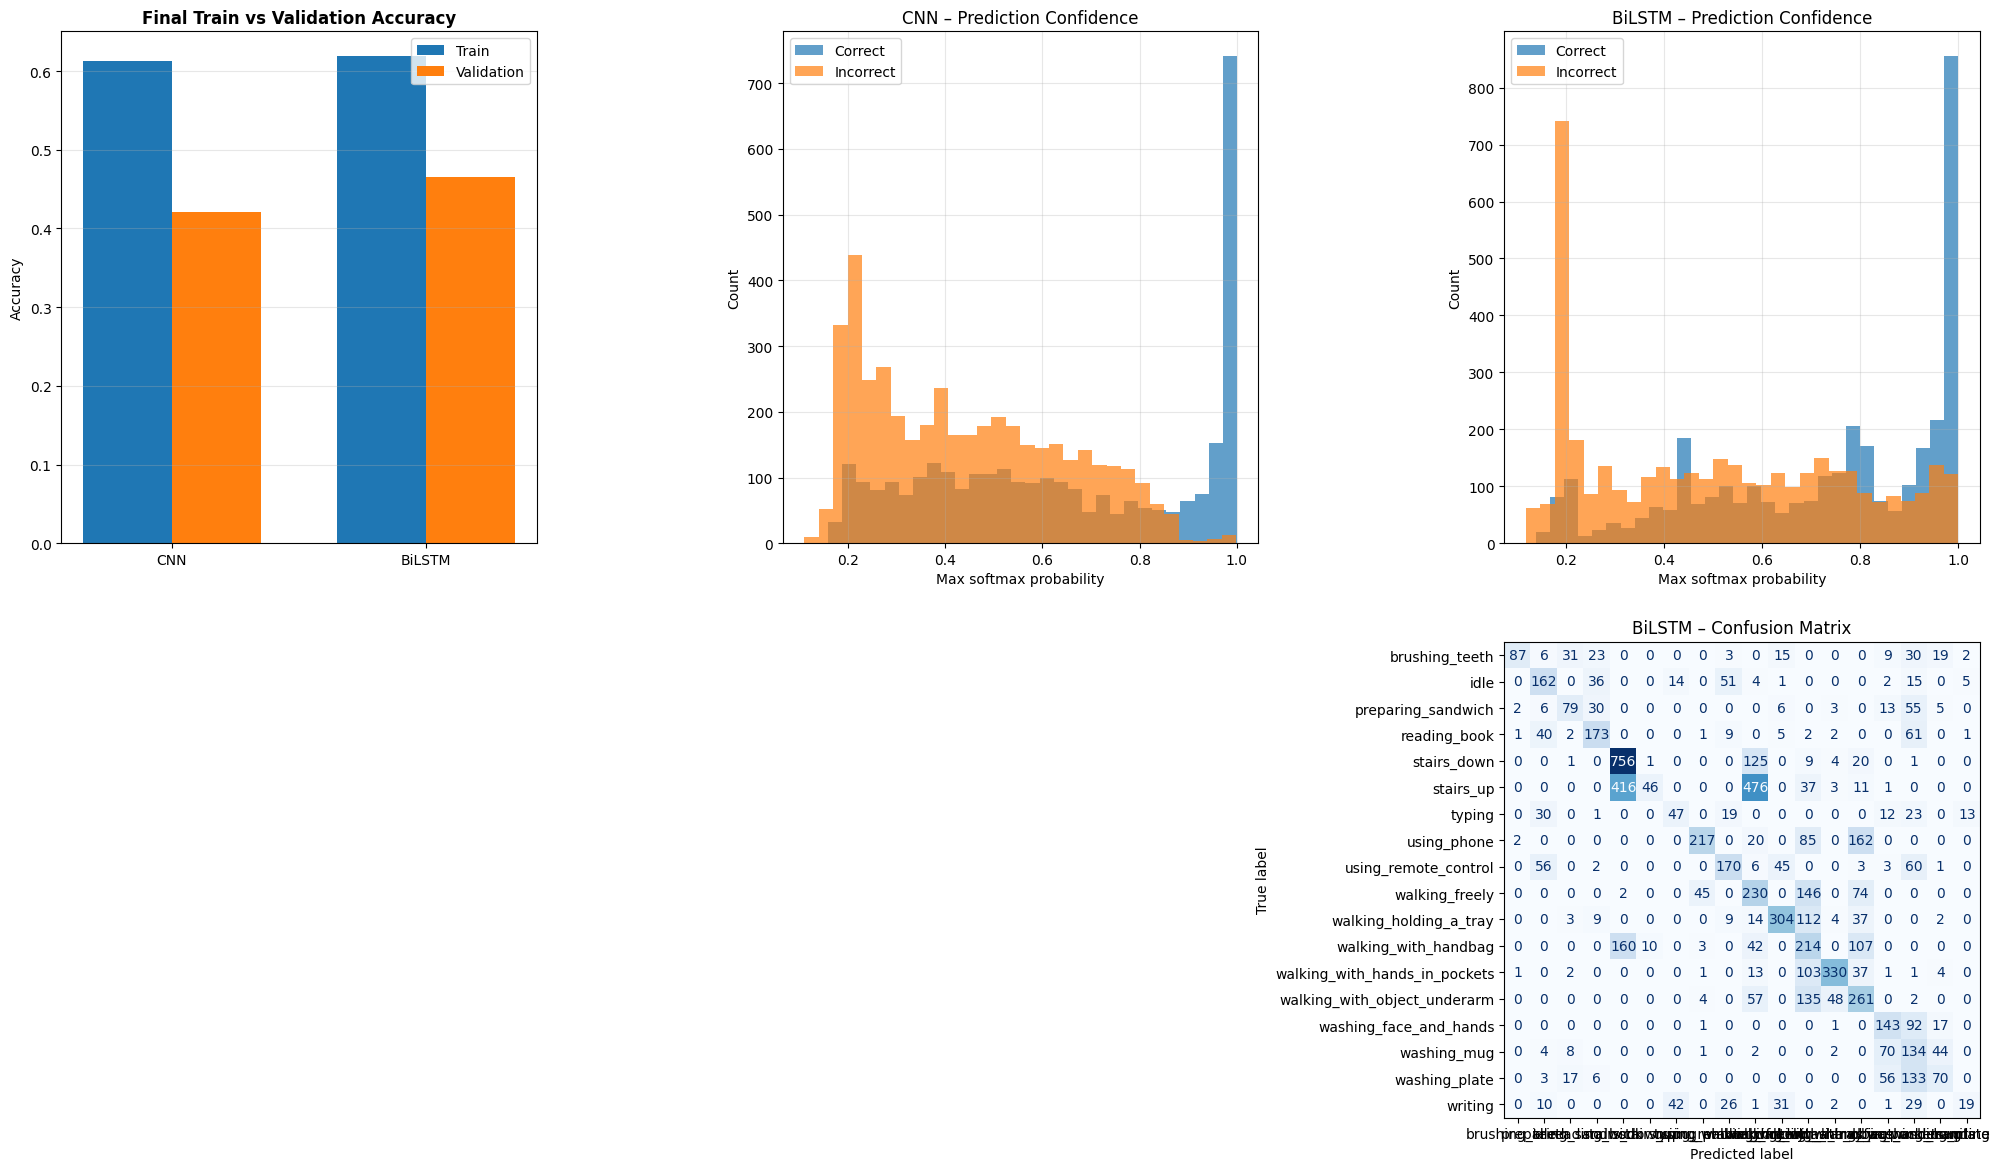

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -------------------------------------------------
# Collect model outputs in ONE place
# -------------------------------------------------
models = {
    "CNN": {
        "train_acc": cnn_train_m["accuracy"],
        "val_acc": cnn_val_m["accuracy"],
        "val_probs": cnn_val_probs,
        "val_preds": cnn_val_preds,
        "val_labels": cnn_val_labels,
    },
    "BiLSTM": {
        "train_acc": lstm_train_m["accuracy"],
        "val_acc": lstm_val_m["accuracy"],
        "val_probs": lstm_val_probs,
        "val_preds": lstm_val_preds,
        "val_labels": lstm_val_labels,
    },
    # Optional (if you want RF later)
    # "RF": {
    #     "train_acc": rf_train_acc,
    #     "val_acc": rf_val_acc,
    #     "val_probs": rf_val_probs,
    #     "val_preds": rf_val_preds,
    #     "val_labels": rf_val_labels,
    # },
}

# -------------------------------------------------
# Figure layout
# -------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# =================================================
# Train vs Val Accuracy (bar plot)
# =================================================
model_names = list(models.keys())
train_accs = [models[m]["train_acc"] for m in model_names]
val_accs   = [models[m]["val_acc"] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(x - width/2, train_accs, width, label="Train")
axes[0, 0].bar(x + width/2, val_accs, width, label="Validation")

axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names)
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].set_title("Final Train vs Validation Accuracy", fontweight="bold")
axes[0, 0].legend()
axes[0, 0].grid(axis="y", alpha=0.3)

# =================================================
# Confidence analysis (CNN & BiLSTM)
# =================================================
def plot_confidence(probs, labels, preds, title, ax):
    max_probs = probs.max(axis=1)
    correct = preds == labels

    ax.hist(max_probs[correct], bins=30, alpha=0.7, label="Correct")
    ax.hist(max_probs[~correct], bins=30, alpha=0.7, label="Incorrect")
    ax.set_title(title)
    ax.set_xlabel("Max softmax probability")
    ax.set_ylabel("Count")
    ax.legend()
    ax.grid(alpha=0.3)

plot_confidence(
    models["CNN"]["val_probs"],
    models["CNN"]["val_labels"],
    models["CNN"]["val_preds"],
    "CNN – Prediction Confidence",
    axes[0, 1],
)

plot_confidence(
    models["BiLSTM"]["val_probs"],
    models["BiLSTM"]["val_labels"],
    models["BiLSTM"]["val_preds"],
    "BiLSTM – Prediction Confidence",
    axes[0, 2],
)

# =================================================
# High-confidence behavior analysis (printed)
# =================================================
def confidence_breakdown(name, probs, labels, preds):
    max_probs = probs.max(axis=1)
    correct = preds == labels

    good = np.sum((correct) & (max_probs > 0.9))
    bad = np.sum((~correct) & (max_probs > 0.9))
    uncertain = np.sum(max_probs < 0.6)

    print(f"{name}")
    print("-" * 40)
    print(f" High-confidence correct (>0.9): {good}")
    print(f" High-confidence wrong   (>0.9): {bad}")
    print(f" Uncertain predictions  (<0.6): {uncertain}")
    print()

confidence_breakdown("CNN (Validation)",
                      models["CNN"]["val_probs"],
                      models["CNN"]["val_labels"],
                      models["CNN"]["val_preds"])

confidence_breakdown("BiLSTM (Validation)",
                      models["BiLSTM"]["val_probs"],
                      models["BiLSTM"]["val_labels"],
                      models["BiLSTM"]["val_preds"])

axes[1, 0].axis("off")
axes[1, 1].axis("off")

# =================================================
# Confusion Matrix (best model by val_acc)
# =================================================
best_model_name = max(models, key=lambda m: models[m]["val_acc"])
best = models[best_model_name]

cm = confusion_matrix(best["val_labels"], best["val_preds"])
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(ax=axes[1, 2], cmap="Blues", colorbar=False)
axes[1, 2].set_title(f"{best_model_name} – Confusion Matrix")

plt.tight_layout()
plt.show()


## 2.E - 	Adjust an external pretrained TS model and fine tune the trained model to the data.
compare the results you got to previous sections (c-d). you may want to try one of MOMENT / TOTEM or try to adjust a forecasting-first model like TimesFM, Tiny Time Mixers or Chronos.

- MOMENT Github Repo: https://github.com/moment-timeseries-foundation-model/moment
- TOTEM Github Repo: https://github.com/SaberaTalukder/TOTEM
- TimesFM: https://github.com/google-research/timesfm
- Tiny Time Mixers: https://github.com/glehet/TTM1
- Chronos: https://github.com/amazon-science/chronos-forecasting

### Install TTM


In [47]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"
! pip install tf-keras
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-no8lbr3o/granite-tsfm_4af7927f73f04c299036d5a95e665919
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-no8lbr3o/granite-tsfm_4af7927f73f04c299036d5a95e665919
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

set_seed(42)

✅ Using device: cuda


In [49]:
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

SUPPORTED_CONTEXTS = [512, 1024, 1536]

# original sequence length
orig_len = train_dataset[0][0].shape[-1]

# pick nearest supported context length
CONTEXT_LENGTH = min(SUPPORTED_CONTEXTS, key=lambda x: abs(x - orig_len))

PREDICTION_LENGTH = 1  # dummy (required by API)

print(f"✅ Original length: {orig_len}")
print(f"✅ Using TTM context length: {CONTEXT_LENGTH}")

ttm_model = get_model(
    TTM_MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    prefer_longer_context=True,
)

ttm_model = ttm_model.to(device)
ttm_model.eval()

# Freeze backbone
for p in ttm_model.parameters():
    p.requires_grad = False

print("✅ TTM backbone loaded & frozen")


INFO:/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/.venv/lib/python3.12/site-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2


✅ Original length: 3
✅ Using TTM context length: 512


INFO:/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/.venv/lib/python3.12/site-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 512-48-ft-r2.1.
INFO:/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/.venv/lib/python3.12/site-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 48


✅ TTM backbone loaded & frozen


In [93]:
## Helper Functions
def pad_or_truncate(x, target_len):
    """
    x: [B, C, T]
    """
    T = x.shape[-1]

    if T == target_len:
        return x

    if T > target_len:
        return x[..., -target_len:]  # keep most recent history

    pad_size = target_len - T
    pad = torch.zeros(*x.shape[:-1], pad_size, device=x.device)
    return torch.cat([pad, x], dim=-1)

def sliding_windows(x, window=512, stride=256):
    B, T, F = x.shape
    windows = []
    for start in range(0, T - window + 1, stride):
        windows.append(x[:, start:start+window, :])
    return torch.stack(windows, dim=1)  # [B, W, window, F]


def extract_ttm_embeddings(x):
    B, T, F = x.shape
    print(f"Inside extract_ttm_embeddings: x.shape={x.shape}")
    context_len = ttm_model.config.context_length
    print("TTM context_length:", context_len)

    # Slice to context length if longer
    if T > context_len:
        print(f"Slicing x from T={T} to context_length={context_len}")
        x = x[:, -context_len:, :]

    freq_token = torch.zeros(B, dtype=torch.long, device=x.device)
    with torch.no_grad():
        outputs = ttm_model(
            past_values=x,
            freq_token=freq_token,
            return_dict=True,
            output_hidden_states=True,
        )

    hidden = outputs.hidden_states[-1]  # last hidden state
    emb = hidden[:, -1, :]  # take last time step
    print("Embeddings shape:", emb.shape)
    return emb

# def extract_ttm_embeddings(x):
#     B, T, F = x.shape
#     windows = sliding_windows(x, window=512, stride=256)

#     B, W, _, _ = windows.shape
#     windows = windows.view(B * W, 512, F)

#     freq_token = torch.zeros(B * W, dtype=torch.long, device=x.device)

#     with torch.no_grad():
#         out = ttm_model(
#             past_values=windows,
#             freq_token=freq_token,
#             output_hidden_states=True,
#             return_dict=True
#         )

#     hidden = out.hidden_states[-1]       # [B*W, tokens, D]
#     # emb = hidden.mean(dim=1)              # [B*W, D]
#     # emb = emb.view(B, W, -1).mean(dim=1)  # [B, D]
#     emb = hidden[:, -1, :] 
#     return emb



In [94]:
class TTMClassifier(nn.Module):
    def __init__(self, emb_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [95]:
with torch.no_grad():
    dummy_x, _ = next(iter(train_loader))
    dummy_x = dummy_x.to(device)

    emb = extract_ttm_embeddings(dummy_x)
    print("TTM embeddings shape:", emb.shape)

    #  Handle both [B, D] and [B, T, D]
    if emb.dim() == 3:
        emb = emb.mean(dim=1)   # token pooling
        print("Applied pooling over tokens")

    print("Final embedding shape:", emb.shape)  # [B, D]

emb_dim = emb.shape[1]
model = TTMClassifier(emb_dim, len(le.classes_)).to(device)
print("TTMClassifier initialized with emb_dim:", emb_dim)

Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
TTM embeddings shape: torch.Size([128, 9, 128])
Applied pooling over tokens
Final embedding shape: torch.Size([128, 128])
TTMClassifier initialized with emb_dim: 128


In [96]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 16

for epoch in range(EPOCHS):
    model.train()
    train_preds, train_labels = [], []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # Extract embeddings
        emb = extract_ttm_embeddings(x)        # [B, T_emb, D_emb]
        emb = emb.mean(dim=1)                  # Pool over sequence -> [B, D_emb]

        logits = model(emb)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_preds.extend(torch.argmax(logits, 1).cpu().numpy())
        train_labels.extend(y.cpu().numpy())

    # Training metrics
    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average="macro")
    train_prec = precision_score(train_labels, train_preds, average="macro")
    train_rec = recall_score(train_labels, train_preds, average="macro")

    # ---- validation ----
    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            emb = extract_ttm_embeddings(x)
            emb = emb.mean(dim=1)  # Pool sequence

            logits = model(emb)

            val_preds.extend(torch.argmax(logits, 1).cpu().numpy())
            val_labels.extend(y.cpu().numpy())

    # Validation metrics
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average="macro")
    val_prec = precision_score(val_labels, val_preds, average="macro")
    val_rec = recall_score(val_labels, val_preds, average="macro")

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Acc: {train_acc:.3f} | Train F1: {train_f1:.3f} | "
        f"Train Prec: {train_prec:.3f} | Train Rec: {train_rec:.3f} || "
        f"Val Acc: {val_acc:.3f} | Val F1: {val_f1:.3f} | "
        f"Val Prec: {val_prec:.3f} | Val Rec: {val_rec:.3f}"
    )


Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=400

## With warmup Epochs, then unfreeze last layer

In [97]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn

# ------------------------
# CONFIG
# ------------------------
EPOCHS = 16
WARMUP_EPOCHS = 5          #  new
LR_HEAD = 1e-3
LR_TTM = 1e-4

criterion = nn.CrossEntropyLoss()

# ------------------------
# Freeze ALL TTM params initially
# ------------------------
for p in ttm_model.parameters():
    p.requires_grad = False

# ------------------------
# Optimizer (HEAD ONLY for warmup)
# ------------------------
optimizer = torch.optim.Adam(
    model.parameters(), lr=LR_HEAD
)

# ------------------------
# Find last TTM layer index ONCE
# ------------------------
last_idx = max(
    int(name.split("layers.")[1].split(".")[0])
    for name, _ in ttm_model.named_parameters()
    if "layers." in name
)

print(f" Last TTM layer index: {last_idx}")

# ------------------------
# TRAINING LOOP
# ------------------------
for epoch in range(EPOCHS):

    # ------------------------
    # UNFREEZE after warmup
    # ------------------------
    if epoch == WARMUP_EPOCHS:
        print(" Unfreezing last TTM block & rebuilding optimizer")

        for name, p in ttm_model.named_parameters():
            if f"layers.{last_idx}." in name:
                p.requires_grad = True

        # Rebuild optimizer (CRITICAL)
        optimizer = torch.optim.AdamW(
            [
                {"params": model.parameters(), "lr": LR_HEAD},
                {
                    "params": [p for p in ttm_model.parameters() if p.requires_grad],
                    "lr": LR_TTM,
                },
            ],
            weight_decay=1e-4,
        )

        trainable = sum(p.numel() for p in ttm_model.parameters() if p.requires_grad)
        print(f"✅ Trainable TTM params: {trainable:,}")

    # ------------------------
    # TRAIN
    # ------------------------
    model.train()
    train_preds, train_labels = [], []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # Extract TTM embeddings
        emb = extract_ttm_embeddings(x)   # [B, tokens, D]
        emb = emb.mean(dim=1)             # token pooling -> [B, D]

        logits = model(emb)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_preds.extend(torch.argmax(logits, 1).cpu().numpy())
        train_labels.extend(y.cpu().numpy())

    # Training metrics
    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average="macro")
    train_prec = precision_score(train_labels, train_preds, average="macro")
    train_rec = recall_score(train_labels, train_preds, average="macro")

    # ------------------------
    # VALIDATION
    # ------------------------
    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            emb = extract_ttm_embeddings(x)
            emb = emb.mean(dim=1)

            logits = model(emb)

            val_preds.extend(torch.argmax(logits, 1).cpu().numpy())
            val_labels.extend(y.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average="macro")
    val_prec = precision_score(val_labels, val_preds, average="macro")
    val_rec = recall_score(val_labels, val_preds, average="macro")

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Acc: {train_acc:.3f} | Train F1: {train_f1:.3f} | "
        f"Train Prec: {train_prec:.3f} | Train Rec: {train_rec:.3f} || "
        f"Val Acc: {val_acc:.3f} | Val F1: {val_f1:.3f} | "
        f"Val Prec: {val_prec:.3f} | Val Rec: {val_rec:.3f}"
    )


 Last TTM layer index: 1
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length: 512
Slicing x from T=4000 to context_length=512
Embeddings shape: torch.Size([128, 9, 128])
Inside extract_ttm_embeddings: x.shape=torch.Size([128, 4000, 3])
TTM context_length:

### 2.F - figure out where & why the model is doing well and suggest at least 3 ways to improve the results

**Analysis: where & why the models are doing well / failing**

**CNN 1D (Validation)**

- High-confidence correct (>0.9): 964

- High-confidence wrong (>0.9): 41

- Uncertain (<0.6): 4543

**What this means**

When the CNN is confident, it is usually correct

Very few catastrophic overconfident errors

But the model is extremely cautious → most predictions are low-confidence


**BiLSTM (Validation)**

- High-confidence correct (>0.9): 1058

- High-confidence wrong (>0.9): 540

- Uncertain (<0.6): 4017

**What this means**

BiLSTM is more confident overall

BUT it makes far more confident mistakes

Overfitting or spurious temporal correlations



- CNN → higher precision, lower recall

- BiLSTM → higher recall, lower precision

### 3 Improvement strategies

1. Class-balanced loss (high impact, low effort)

**Why?**

The models show confidence imbalance, Some classes likely dominate

CrossEntropyLoss treats all classes equally which is bad for recall and F1

**Fix**

- Use class-weighted CrossEntropy or Focal Loss

**Expected improvement:**

- Better F1-Score

- Less confident wrong predictions (especially BiLSTM)


2. Confidence calibration (HIGH impact)

The models’ probabilities are not calibrated: CNN is under-confident and BiLSTM is over-confident

**Fix:** Label smoothing

**Expected improvement:**

- CNN: fewer uncertain predictions

- BiLSTM: fewer confident mistakes


3. Better temporal invariance and normalization (HIGH impact)

**Why?**

Both models are sensitive to user- and sensor-specific variations. The CNN’s large number of low-confidence predictions suggests it struggles to generalize across different motion styles and sequence lengths, while the BiLSTM’s confident mistakes indicate reliance on spurious temporal correlations that do not transfer well to unseen subjects.

**Fix**

Apply per-sequence or per-channel normalization (e.g., z-score)

Introduce simple time-series augmentations (noise, time jitter, random cropping)

**Expected improvement:**

CNN: fewer uncertain predictions and improved recall

BiLSTM: fewer confident wrong predictions and better generalization

### 2.G - Prioritize the list of suggestions for improvements and implement the first 2 suggestions, repeat section d. and present a table of all your results

## Improvement 1: Compute class weights for Class-weighted loss

In [53]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Extract labels from training dataset
train_labels = []

for _, labels in train_loader:
    train_labels.extend(labels.cpu().numpy())

train_labels = np.array(train_labels)

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class weights:", class_weights)


Class weights: tensor([ 1.9679,  0.9984,  1.1655,  1.0770, 10.0049,  8.9518,  2.2592,  0.6222,
         1.0794,  0.5835,  0.6033,  0.5992,  0.6350,  0.6098,  1.0649,  1.0635,
         1.0740,  2.2212])


### Improved 1D_CNN NN (With Improvement #2 Label Smoothing)

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import lightning as L

class CNN1DClassifierV2(L.LightningModule):
    def __init__(self, num_classes=6, lr=1e-3, class_weights=None):
        super().__init__()
        self.save_hyperparameters(ignore=["class_weights"])
        self.num_classes = num_classes

        # 1D-CNN: Multi-kernel (Inception style)
        self.conv1 = nn.Sequential(
            nn.Conv1d(3, 64, 7, padding=3), nn.ReLU(), nn.BatchNorm1d(64), nn.MaxPool1d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(3, 64, 15, padding=7), nn.ReLU(), nn.BatchNorm1d(64), nn.MaxPool1d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(3, 64, 31, padding=15), nn.ReLU(), nn.BatchNorm1d(64), nn.MaxPool1d(2)
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64*3, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        #  IMPROVEMENTS HERE
        # ------------------
        self.criterion = nn.CrossEntropyLoss(
            weight=class_weights,
            label_smoothing=0.1  #  Improvement #2
        )
        # Metrics
        self.val_f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.val_predictions = []
        self.val_probs = []

    def forward(self, x):
        x = x.transpose(1, 2)  # [B, T, 3] -> [B, 3, T]

        c1 = self.conv1(x)
        c2 = self.conv2(x)
        c3 = self.conv3(x)

        c1 = self.global_pool(c1).flatten(1)
        c2 = self.global_pool(c2).flatten(1)
        c3 = self.global_pool(c3).flatten(1)

        x = torch.cat([c1, c2, c3], dim=1)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1)

        # Compute loss
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)

        # Accuracy
        acc = (pred == y).float().mean()
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)

        # F1
        f1 = self.val_f1_metric(pred, y)
        self.log('val_f1', f1, prog_bar=True, on_step=False, on_epoch=True)

        # Store for analysis (optional, only first batch)
        if batch_idx == 0:
            self.val_predictions.extend(pred.cpu().numpy())
            self.val_probs.extend(probs.cpu().numpy())

    def on_validation_epoch_end(self):
        # Reset metric at the end of each epoch
        self.val_f1_metric.reset()

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)

print("✅ 1D-CNN Model fixed (val_f1 with torchmetrics, logging compatible with Lightning & MLflow)")


✅ 1D-CNN Model fixed (val_f1 with torchmetrics, logging compatible with Lightning & MLflow)


### Improved BiLSTM NN (With Improvement #2 Label Smoothing)

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import lightning as L

class BiLSTMClassifierV2(L.LightningModule):
    def __init__(self, num_classes=6, hidden_size=128, num_layers=2, lr=1e-3, class_weights=None):
        super().__init__()
        self.save_hyperparameters(ignore=["class_weights"])
        self.num_classes = num_classes

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=3,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_size*2, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        # IMPROVEMENT HERE
        self.criterion = nn.CrossEntropyLoss(
            weight=class_weights,
            label_smoothing=0.1
        )

        # Metrics
        self.val_f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.val_predictions = []
        self.val_probs = []

    def forward(self, x):
        # x: [B, T, 3]
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat([h_n[-2], h_n[-1]], dim=1)  # Last hidden states (forward + backward)
        return self.fc(h_n)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1)

        # Loss
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)

        # Accuracy
        acc = (pred == y).float().mean()
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)

        # F1
        f1 = self.val_f1_metric(pred, y)
        self.log('val_f1', f1, prog_bar=True, on_step=False, on_epoch=True)

        # Store for analysis (optional)
        if batch_idx == 0:
            self.val_predictions.extend(pred.cpu().numpy())
            self.val_probs.extend(probs.cpu().numpy())

    def on_validation_epoch_end(self):
        # Reset metric at the end of each epoch
        self.val_f1_metric.reset()

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)


print("✅ BiLSTM Model fixed (Bidirectional + Last hidden state + val_f1)")


✅ BiLSTM Model fixed (Bidirectional + Last hidden state + val_f1)


### Train both Improved Models

In [56]:
from pytorch_lightning.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import EarlyStopping

# DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True
)

mlf_logger_cnn_v2 = MLFlowLogger(
    experiment_name="Deep Learning Experiment",
    run_name="CNN_1D_V2"
)

mlf_logger_lstm_v2 = MLFlowLogger(
    experiment_name="Deep Learning Experiment",
    run_name="BiLSTM_V2"
)

best_ckpt_cnn_v2 = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="cnn-best-acc-64-{epoch:02d}-{val_acc:.3f}",
)

best_ckpt_lstm_v2 = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="lstm-best-acc-64-{epoch:02d}-{val_acc:.3f}",
)

# Train CNN Improved
print("\n🚀 Training 1D-CNN V2...")
cnn_model_v2 = CNN1DClassifierV2(num_classes=len(le.classes_),
    class_weights=class_weights)
# logger_cnn = TensorBoardLogger("tb_logs", name="cnn")
trainer_cnn = L.Trainer(
    max_epochs=64,
    logger=mlf_logger_cnn_v2,
    callbacks=[
        EarlyStopping(monitor='val_acc', patience=10, mode='max'),
        best_ckpt_cnn_v2,
    ],
    accelerator='gpu',
    devices=1,
    benchmark=True,
    precision=16,
    log_every_n_steps=10,
)
trainer_cnn.fit(cnn_model_v2, train_loader, val_loader)

# Train BiLSTM
print("\n🚀 Training BiLSTM V2...")
lstm_model_v2 = BiLSTMClassifierV2( num_classes=len(le.classes_),
    hidden_size=128,
    class_weights=class_weights)
# logger_lstm = TensorBoardLogger("tb_logs", name="lstm")
trainer_lstm = L.Trainer(
    max_epochs=48,
    logger=mlf_logger_lstm_v2,
    callbacks=[
        EarlyStopping(monitor='val_acc', patience=10, mode='max'),
        best_ckpt_lstm_v2,
    ],
    accelerator='gpu',
    devices=1,
    benchmark=True,
    precision=16,
    log_every_n_steps=10,
)
trainer_lstm.fit(lstm_model_v2, train_loader, val_loader)

print("✅ Both Improved models trained!")


Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



🚀 Training 1D-CNN V2...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ conv1         │ Sequential        │  1.5 K │ train │     0 │
│ 1 │ conv2         │ Sequential        │  3.1 K │ train │     0 │
│ 2 │ conv3         │ Sequential        │  6.1 K │ train │     0 │
│ 3 │ global_pool   │ AdaptiveAvgPool1d │      0 │ train │     0 │
│ 4 │ fc            │ Sequential        │ 27.3 K │ train │     0 │
│ 5 │ criterion     │ CrossEntropyLoss  │      0 │ train │     0 │
│ 6 │ val_f1_metric │ MulticlassF1Score │      0 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 38.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 38.0 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 25                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



🚀 Training BiLSTM V2...


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ lstm          │ LSTM              │  531 K │ train │     0 │
│ 1 │ fc            │ Sequential        │ 35.5 K │ train │     0 │
│ 2 │ criterion     │ CrossEntropyLoss  │      0 │ train │     0 │
│ 3 │ val_f1_metric │ MulticlassF1Score │      0 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 566 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 566 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 10                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

✅ Both Improved models trained!


### Save Checkpoints for improved models

In [57]:
import os
import shutil

# Path of best checkpoint selected by ModelCheckpoint
best_path_blstm_v2 = best_ckpt_lstm_v2.best_model_path
best_path_cnn_v2 = best_ckpt_cnn_v2.best_model_path
print("Best BiLSTM checkpoint:", best_path_blstm_v2)
print("Best CNN checkpoint:", best_path_cnn_v2)

# Save a clean copy with a fixed name
checkpoint_path_blstm_best_v2 = "bilstm_best_48_v2.ckpt"
checkpoint_path_cnn_best_v2 = "cnn_best_64_v2.ckpt"
shutil.copy(best_path_blstm_v2, checkpoint_path_blstm_best_v2)
shutil.copy(best_path_cnn_v2, checkpoint_path_cnn_best_v2)


print(f"Best model checkpoint saved as: {checkpoint_path_blstm_best_v2}")
print(f"Full path: {os.path.abspath(checkpoint_path_blstm_best_v2)}")
print(f"Best model checkpoint saved as: {checkpoint_path_cnn_best_v2}")
print(f"Full path: {os.path.abspath(checkpoint_path_cnn_best_v2)}")
LOCAL = True  # set False if running in Colab

if LOCAL:
    print(f"LOCAL MODE: Checkpoint already saved locally at '{checkpoint_path_blstm_best_v2}'")
    print(f"LOCAL MODE: Checkpoint already saved locally at '{checkpoint_path_cnn_best_v2}'")
    print("   No download needed.")
else:
    from google.colab import files
    files.download(checkpoint_path_cnn_best_v2)
    files.download(checkpoint_path_blstm_best_v2)
    print("Downloading checkpoint to your local machine...")


Best BiLSTM checkpoint: ./mlruns/823012891375308118/a3e5ab3cf933471eaec02345b0a713fc/checkpoints/lstm-best-acc-64-epoch=12-val_acc=0.369.ckpt
Best CNN checkpoint: ./mlruns/823012891375308118/23109ac0ecd143af9e2b4c3114c29a66/checkpoints/cnn-best-acc-64-epoch=08-val_acc=0.511.ckpt
Best model checkpoint saved as: bilstm_best_48_v2.ckpt
Full path: /home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/bilstm_best_48_v2.ckpt
Best model checkpoint saved as: cnn_best_64_v2.ckpt
Full path: /home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/cnn_best_64_v2.ckpt
LOCAL MODE: Checkpoint already saved locally at 'bilstm_best_48_v2.ckpt'
LOCAL MODE: Checkpoint already saved locally at 'cnn_best_64_v2.ckpt'
   No download needed.


In [58]:
import mlflow
import mlflow.pytorch

# -------------------------------------------------
# Ensure MLflow experiment exists
# -------------------------------------------------
mlflow.set_experiment("Deep Learning Experiment")

# -------------------------------------------------
# Load BEST models from the copied checkpoints
# -------------------------------------------------
best_cnn_v2 = CNN1DClassifierV2.load_from_checkpoint("cnn_best_64_v2.ckpt", strict=False)
best_bilstm_v2 = BiLSTMClassifierV2.load_from_checkpoint("bilstm_best_48_v2.ckpt", strict=False)

best_cnn_v2.eval()
best_bilstm_v2.eval()

print("Loaded best CNN and BiLSTM V2 Improved models")


# End any active run
if mlflow.active_run() is not None:
    mlflow.end_run()

# Now you can start a new run safely
with mlflow.start_run(run_name="BEST_MODELS_Improved"):
    mlflow.pytorch.log_model(best_cnn_v2, artifact_path="cnn_best_model_64_v2")
    mlflow.pytorch.log_model(best_bilstm_v2, artifact_path="bilstm_best_model_48_v2")

# -------------------------------------------------
# Log BOTH models to MLflow
# -------------------------------------------------
with mlflow.start_run(run_name="BEST_MODELS_Improved"):
    mlflow.pytorch.log_model(
        best_cnn_v2,
        artifact_path="cnn_best_model_64_v2"
    )

    mlflow.pytorch.log_model(
        best_bilstm_v2,
        artifact_path="bilstm_best_model_48_v2"
    )

print("Both Improved best models logged to MLflow successfully")


2026/01/01 20:59:38 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...


Loaded best CNN and BiLSTM V2 Improved models


2026/01/01 20:59:38 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2026/01/01 20:59:38 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2026/01/01 20:59:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2026/01/01 20:59:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/01 20:59:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/01 20:59:45 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflo

Both Improved best models logged to MLflow successfully


### Evaluate Improved Models

In [59]:
import torch

# ----------------------------------
# Load BEST IMPROVED CNN
# ----------------------------------
best_model_1d_cnn_v2 = CNN1DClassifierV2.load_from_checkpoint(
    "cnn_best_64_v2.ckpt",strict=False,
    map_location=device
)

best_model_1d_cnn_v2.eval()

cnn_train_m, _, _, _ = evaluate_model(
    best_model_1d_cnn_v2,
    train_loader,
    criterion=best_model_1d_cnn_v2.criterion,  #  USE INTERNAL LOSS
    device=device
)

cnn_val_m, cnn_val_preds, cnn_val_probs, cnn_val_labels = evaluate_model(
    best_model_1d_cnn_v2,
    val_loader,
    criterion=best_model_1d_cnn_v2.criterion,  #  USE INTERNAL LOSS
    device=device
)

# ----------------------------------
# Load BEST IMPROVED BiLSTM
# ----------------------------------
best_model_bilstm_v2 = BiLSTMClassifierV2.load_from_checkpoint(
    "bilstm_best_48_v2.ckpt",strict=False,
    map_location=device
)

best_model_bilstm_v2.eval()

lstm_train_m, _, _, _ = evaluate_model(
    best_model_bilstm_v2,
    train_loader,
    criterion=best_model_bilstm_v2.criterion,  #  USE INTERNAL LOSS
    device=device
)

lstm_val_m, lstm_val_preds, lstm_val_probs, lstm_val_labels = evaluate_model(
    best_model_bilstm_v2,
    val_loader,
    criterion=best_model_bilstm_v2.criterion,  #  USE INTERNAL LOSS
    device=device
)

# -------- Pretty print --------
def print_metrics(name, train_m, val_m):
    print(f"\n{name}")
    print("-" * 50)
    print(
        f"Train | "
        f"Loss {train_m['loss']:.4f} | "
        f"Acc {train_m['accuracy']:.3f} | "
        f"P {train_m['precision']:.3f} | "
        f"R {train_m['recall']:.3f} | "
        f"F1 {train_m['f1']:.3f}"
    )
    print(
        f"Val   | "
        f"Loss {val_m['loss']:.4f} | "
        f"Acc {val_m['accuracy']:.3f} | "
        f"P {val_m['precision']:.3f} | "
        f"R {val_m['recall']:.3f} | "
        f"F1 {val_m['f1']:.3f}"
    )

print_metrics("CNN 1D V2 Improved", cnn_train_m, cnn_val_m)
print_metrics("BiLSTM V2 Improved", lstm_train_m, lstm_val_m)


CNN 1D V2 Improved
--------------------------------------------------
Train | Loss 1.6526 | Acc 0.547 | P 0.573 | R 0.601 | F1 0.554
Val   | Loss 1.7255 | Acc 0.511 | P 0.572 | R 0.517 | F1 0.509

BiLSTM V2 Improved
--------------------------------------------------
Train | Loss 2.1011 | Acc 0.319 | P 0.356 | R 0.368 | F1 0.304
Val   | Loss 1.9564 | Acc 0.369 | P 0.385 | R 0.330 | F1 0.296


In [60]:
import mlflow

# -------- CNN (Improved) --------
for k, v in cnn_train_m.items():
    mlflow.log_metric(f"cnn_train_{k}", v)

for k, v in cnn_val_m.items():
    mlflow.log_metric(f"cnn_val_{k}", v)

# -------- BiLSTM (Improved) --------
for k, v in lstm_train_m.items():
    mlflow.log_metric(f"bilstm_train_{k}", v)

for k, v in lstm_val_m.items():
    mlflow.log_metric(f"bilstm_val_{k}", v)


2026/01/01 21:01:43 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2026/01/01 21:01:43 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


### Visualize Results

CNN Improved (Validation)
----------------------------------------
 High-confidence correct (>0.9): 101
 High-confidence wrong   (>0.9): 0
 Uncertain predictions  (<0.6): 5670

BiLSTM Improved (Validation)
----------------------------------------
 High-confidence correct (>0.9): 0
 High-confidence wrong   (>0.9): 0
 Uncertain predictions  (<0.6): 7229



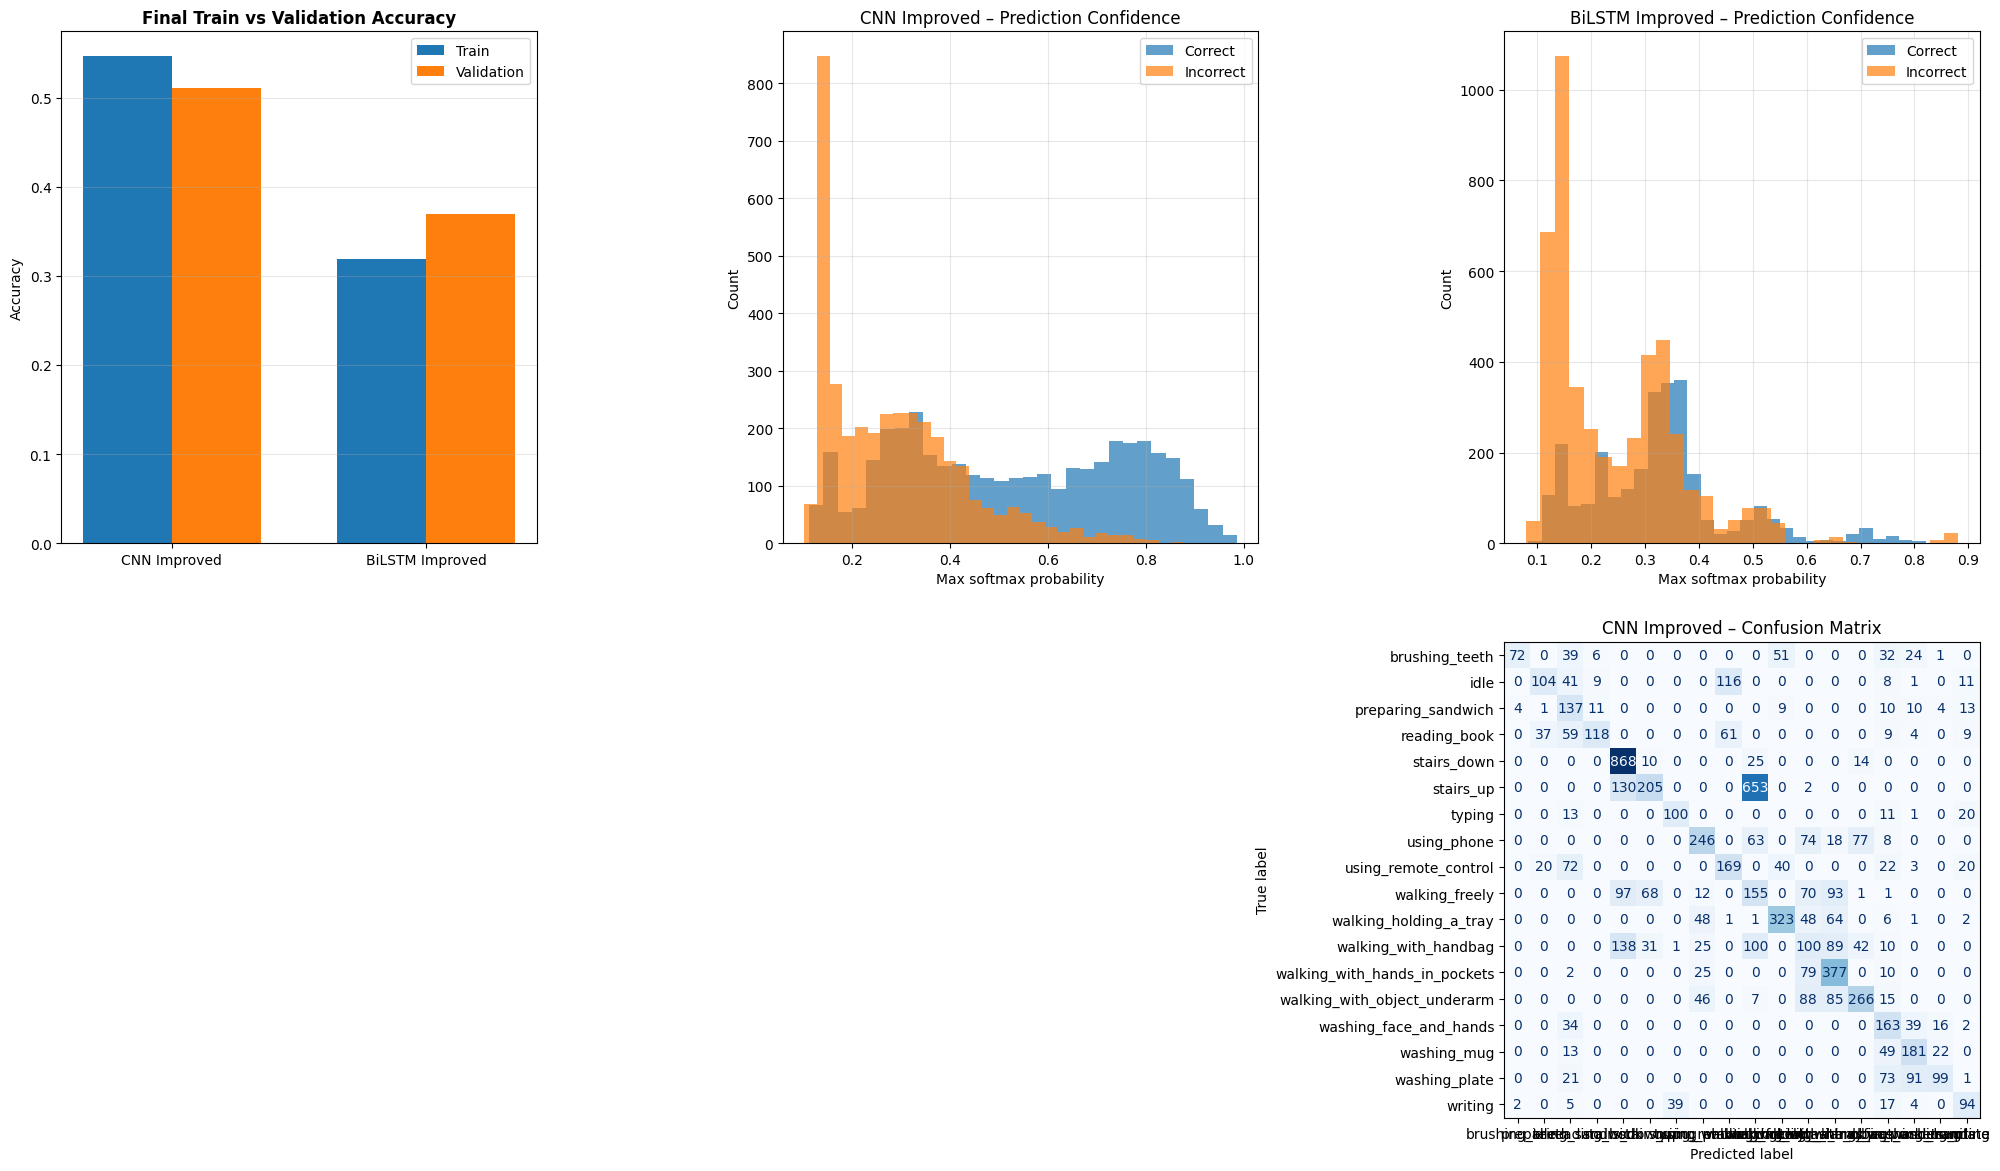

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -------------------------------------------------
# Collect model outputs in ONE place
# -------------------------------------------------
models = {
    "CNN Improved": {
        "train_acc": cnn_train_m["accuracy"],
        "val_acc": cnn_val_m["accuracy"],
        "val_probs": cnn_val_probs,
        "val_preds": cnn_val_preds,
        "val_labels": cnn_val_labels,
    },
    "BiLSTM Improved": {
        "train_acc": lstm_train_m["accuracy"],
        "val_acc": lstm_val_m["accuracy"],
        "val_probs": lstm_val_probs,
        "val_preds": lstm_val_preds,
        "val_labels": lstm_val_labels,
    },
}

# -------------------------------------------------
# Figure layout
# -------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# =================================================
# Train vs Val Accuracy (bar plot)
# =================================================
model_names = list(models.keys())
train_accs = [models[m]["train_acc"] for m in model_names]
val_accs   = [models[m]["val_acc"] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(x - width/2, train_accs, width, label="Train")
axes[0, 0].bar(x + width/2, val_accs, width, label="Validation")

axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names)
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].set_title("Final Train vs Validation Accuracy", fontweight="bold")
axes[0, 0].legend()
axes[0, 0].grid(axis="y", alpha=0.3)

# =================================================
# Confidence analysis (CNN & BiLSTM)
# =================================================
def plot_confidence(probs, labels, preds, title, ax):
    max_probs = probs.max(axis=1)
    correct = preds == labels

    ax.hist(max_probs[correct], bins=30, alpha=0.7, label="Correct")
    ax.hist(max_probs[~correct], bins=30, alpha=0.7, label="Incorrect")
    ax.set_title(title)
    ax.set_xlabel("Max softmax probability")
    ax.set_ylabel("Count")
    ax.legend()
    ax.grid(alpha=0.3)

plot_confidence(
    models["CNN Improved"]["val_probs"],
    models["CNN Improved"]["val_labels"],
    models["CNN Improved"]["val_preds"],
    "CNN Improved – Prediction Confidence",
    axes[0, 1],
)

plot_confidence(
    models["BiLSTM Improved"]["val_probs"],
    models["BiLSTM Improved"]["val_labels"],
    models["BiLSTM Improved"]["val_preds"],
    "BiLSTM Improved – Prediction Confidence",
    axes[0, 2],
)

# =================================================
# High-confidence behavior analysis (printed)
# =================================================
def confidence_breakdown(name, probs, labels, preds):
    max_probs = probs.max(axis=1)
    correct = preds == labels

    good = np.sum((correct) & (max_probs > 0.9))
    bad = np.sum((~correct) & (max_probs > 0.9))
    uncertain = np.sum(max_probs < 0.6)

    print(f"{name}")
    print("-" * 40)
    print(f" High-confidence correct (>0.9): {good}")
    print(f" High-confidence wrong   (>0.9): {bad}")
    print(f" Uncertain predictions  (<0.6): {uncertain}")
    print()

confidence_breakdown("CNN Improved (Validation)",
                      models["CNN Improved"]["val_probs"],
                      models["CNN Improved"]["val_labels"],
                      models["CNN Improved"]["val_preds"])

confidence_breakdown("BiLSTM Improved (Validation)",
                      models["BiLSTM Improved"]["val_probs"],
                      models["BiLSTM Improved"]["val_labels"],
                      models["BiLSTM Improved"]["val_preds"])

axes[1, 0].axis("off")
axes[1, 1].axis("off")

# =================================================
# Confusion Matrix (best model by val_acc)
# =================================================
best_model_name = max(models, key=lambda m: models[m]["val_acc"])
best = models[best_model_name]

cm = confusion_matrix(best["val_labels"], best["val_preds"])
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(ax=axes[1, 2], cmap="Blues", colorbar=False)
axes[1, 2].set_title(f"{best_model_name} – Confusion Matrix")

plt.tight_layout()
plt.show()


In [63]:
print(train_df.columns.tolist())


['Unnamed: 0', 'userid', 'activity', 'sensor', 'body_part', 'side', 'id', 'sequence_length']


# Submission code

### First with Improved CNN

In [67]:
# ============================================
# FINAL SUBMISSION PIPELINE (FIXED SHAPE)
# ============================================
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader

# ---------------------------------
# CONFIG
# ---------------------------------
DEVICE = device
RAW_DIR = "/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/hw2_data/unlabeled/unlabeled"
CHECKPOINT_PATH = "cnn_best_64_v2.ckpt"
SUBMISSION_PATH = "212112106_improved_cnn_submission_64_v2.csv"
BATCH_SIZE = 128
FIXED_LEN = 3000   # MUST match training

# ---------------------------------
# LOAD SAMPLE SUBMISSION
# ---------------------------------
sample_df = pd.read_csv("sample_submission.csv")
submission_ids = sample_df["sample_id"].astype(int).values
class_columns = sample_df.columns[1:]

print("Submission samples:", len(submission_ids))
print("Classes:", len(class_columns))

# ---------------------------------
# RAW TEST DATASET (CORRECT SHAPE)
# ---------------------------------
class RawTestDataset(Dataset):
    def __init__(self, sample_ids, raw_dir):
        self.sample_ids = sample_ids
        self.raw_dir = raw_dir

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        path = os.path.join(self.raw_dir, f"{sample_id}.csv")

        df = pd.read_csv(path)

        # TYPE #1
        if "measurement type" in df.columns:
            df = df[df["measurement type"] == "acceleration [m/s/s]"]
            df = df[["x", "y", "z"]]

        # TYPE #2
        else:
            df = df.select_dtypes(include=[np.number])

        x = df.values.astype(np.float32)  # convert to float

        # Drop NaNs / enforce 3 columns
        x = np.nan_to_num(x)  # replace NaN with 0
        if x.shape[1] != 3:
            # fix shape if not 3 columns
            if x.shape[1] > 3:
                x = x[:, :3]
            else:
                # pad missing channels with zeros
                pad_cols = np.zeros((x.shape[0], 3 - x.shape[1]), dtype=np.float32)
                x = np.hstack([x, pad_cols])

        # truncate / pad time dimension
        x = x[:FIXED_LEN]
        if x.shape[0] < FIXED_LEN:
            pad = np.zeros((FIXED_LEN - x.shape[0], x.shape[1]), dtype=np.float32)
            x = np.vstack([x, pad])


        # 🔥 DO NOT FLATTEN 🔥
        # shape = [T, 3]
        return torch.tensor(x), sample_id

# ---------------------------------
# DATALOADER
# ---------------------------------
test_loader = DataLoader(
    RawTestDataset(submission_ids, RAW_DIR),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("✅ Test loader ready")

# ---------------------------------
# LOAD MODEL
# ---------------------------------
model = CNN1DClassifierV2.load_from_checkpoint(
    CHECKPOINT_PATH,
    map_location=DEVICE,
    strict=False
)

model.to(DEVICE)
model.eval()
print("✅ Model loaded")

# ---------------------------------
# INFERENCE
# ---------------------------------
softmax = torch.nn.Softmax(dim=1)
all_probs, all_ids = [], []

with torch.no_grad():
    for x, ids in test_loader:
        x = x.to(DEVICE)          # [B, T, 3]
        logits = model(x)         # works now
        probs = softmax(logits)

        all_probs.append(probs.cpu().numpy())
        all_ids.append(ids.numpy())

all_probs = np.vstack(all_probs)
all_ids = np.concatenate(all_ids)

print("Prediction shape:", all_probs.shape)

# ---------------------------------
# BUILD SUBMISSION
# ---------------------------------
submission_df = pd.DataFrame(all_probs, columns=class_columns)
submission_df.insert(0, "sample_id", all_ids)

submission_df = submission_df.sort_values("sample_id").reset_index(drop=True)

# ---------------------------------
# SANITY CHECKS
# ---------------------------------
assert len(submission_df) == 74744
assert submission_df.isna().sum().sum() == 0
assert np.allclose(
    submission_df[class_columns].sum(axis=1),
    1.0,
    atol=1e-4
)

# ---------------------------------
# SAVE
# ---------------------------------
submission_df.to_csv(SUBMISSION_PATH, index=False)
print("✅ Submission saved:", SUBMISSION_PATH)

submission_df.head()

Submission samples: 74744
Classes: 18
✅ Test loader ready
✅ Model loaded
Prediction shape: (74744, 18)
✅ Submission saved: 212112106_improved_cnn_submission_64_v2.csv


sample_id  brushing_teeth      idle  preparing_sandwich  reading_book  \
0          1        0.124722  0.032506            0.035941      0.026814   
1          9        0.123258  0.010495            0.108295      0.019803   
2         12        0.120215  0.013548            0.104871      0.029701   
3         16        0.154418  0.025500            0.181985      0.065062   
4         17        0.149909  0.023043            0.196218      0.063402   

   stairs_down  stairs_up    typing  using_phone  using_remote_control  \
0     0.048690   0.055301  0.024990     0.066576              0.045443   
1     0.080685   0.085417  0.006692     0.003702              0.023540   
2     0.067665   0.066163  0.005282     0.003806              0.021547   
3     0.070200   0.065536  0.005483     0.003578              0.025015   
4     0.069241   0.065848  0.005541     0.003629              0.023435   

   walking_freely  walking_holding_a_tray  walking_with_handbag  \
0        0.019960                0.011778              0.020622   
1        0.003750                0.438326              0.004118   
2        0.004091                0.503282              0.004258   
3        0.004297                0.351089              0.004051   
4        0.004310                0.346729              0.004200   

   walking_with_hands_in_pockets  walking_with_object_underarm  \
0                       0.040027                      0.019721   
1                       0.038984                      0.001791   
2                       0.019070                      0.002224   
3                       0.007598                      0.002771   
4                       0.008379                      0.003089   

   washing_face_and_hands  washing_mug  washing_plate   writing  
0                0.232210     0.100804       0.064553  0.029343  
1                0.006261     0.021310       0.016350  0.007224  
2                0.004121     0.012615       0.011352  0.006190  
3                0.003786     0.010095       0.012023  0.007511  
4                0.004005     0.009822       0.012187  0.007013

## Additional Models we tried

In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
!pip install xgboost
import xgboost as xgb
import pandas as pd

xgb_results = []

for fold in range(len(feature_matrices)):
    X_train, X_val = feature_matrices[fold]
    y_train, y_val = labels_list[fold]

    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)

    num_classes = len(le.classes_)

    # -------------------------
    # XGBoost model
    # -------------------------
    xgb_model = xgb.XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax" if num_classes > 2 else "binary:logistic",
        num_class=num_classes if num_classes > 2 else None,
        eval_metric="mlogloss" if num_classes > 2 else "logloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    )

    # Train
    xgb_model.fit(X_train, y_train_enc)

    # Predict
    train_pred = xgb_model.predict(X_train)
    val_pred = xgb_model.predict(X_val)

    train_acc = accuracy_score(y_train_enc, train_pred)
    val_acc = accuracy_score(y_val_enc, val_pred)

    xgb_results.append({
        "fold": fold,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "features": X_train.shape[1]
    })

    print(f"Fold {fold}: XGB Train {train_acc:.3f} | Val {val_acc:.3f}")

xgb_df = pd.DataFrame(xgb_results)
print(
    f"\nXGBoost Benchmark: "
    f"{xgb_df['val_acc'].mean():.3f} ± {xgb_df['val_acc'].std():.3f}"
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 6.2 MB/s eta 0:00:0000:0100:01
Fold 0: XGB Train 1.000 | Val 0.606
Fold 1: XGB Train 1.000 | Val 0.520
Fold 2: XGB Train 1.000 | Val 0.556

XGBoost Benchmark: 0.561 ± 0.043


## Train XGBOOST with RF and create Ensemble 

In [70]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np
import pandas as pd

ensemble_results = []

RF_WEIGHT = 0.3
XGB_WEIGHT = 0.7

for fold in range(len(feature_matrices)):
    X_train, X_val = feature_matrices[fold]
    y_train, y_val = labels_list[fold]

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_val_enc = le.transform(y_val)

    num_classes = len(le.classes_)

    # -------------------------
    # Random Forest (stronger)
    # -------------------------
    rf = RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train_enc)

    rf_val_probs = rf.predict_proba(X_val)

    # -------------------------
    # XGBoost (tuned)
    # -------------------------
    xgb_model = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=8,
        learning_rate=0.03,
        subsample=0.85,
        colsample_bytree=0.85,
        min_child_weight=3,
        gamma=0.5,
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    )
    xgb_model.fit(X_train, y_train_enc)

    xgb_val_probs = xgb_model.predict_proba(X_val)

    # -------------------------
    # Weighted soft-voting
    # -------------------------
    ensemble_probs = (
        RF_WEIGHT * rf_val_probs +
        XGB_WEIGHT * xgb_val_probs
    )

    ensemble_pred = np.argmax(ensemble_probs, axis=1)
    val_acc = accuracy_score(y_val_enc, ensemble_pred)

    ensemble_results.append(val_acc)
    print(f"Fold {fold}: Ensemble Val Acc = {val_acc:.3f}")

print(
    f"\nENSEMBLE Accuracy: "
    f"{np.mean(ensemble_results):.3f} ± {np.std(ensemble_results):.3f}"
)


Fold 0: Ensemble Val Acc = 0.608
Fold 1: Ensemble Val Acc = 0.522
Fold 2: Ensemble Val Acc = 0.570

ENSEMBLE Accuracy: 0.567 ± 0.035


## Stack RF + XGB with Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
# FULL TRAIN DATA (no folds)
X_full = np.vstack([fm[0] for fm in feature_matrices])
y_full = np.concatenate([lbl[0] for lbl in labels_list])

le = LabelEncoder()
y_full_enc = le.fit_transform(y_full)
num_classes = len(le.classes_)

from sklearn.model_selection import StratifiedKFold

INNER_FOLDS = 5
oof_meta = np.zeros((len(X_full), num_classes * 2))

skf = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=42)

for tr_idx, oof_idx in skf.split(X_full, y_full_enc):
    X_tr, X_oof = X_full[tr_idx], X_full[oof_idx]
    y_tr = y_full_enc[tr_idx]

    rf = RandomForestClassifier(
        n_estimators=1000,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_tr, y_tr)

    xgb_model = xgb.XGBClassifier(
        n_estimators=1000,
        max_depth=8,
        learning_rate=0.03,
        subsample=0.85,
        colsample_bytree=0.85,
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    )
    xgb_model.fit(X_tr, y_tr)

    oof_meta[oof_idx] = np.hstack([
        rf.predict_proba(X_oof),
        xgb_model.predict_proba(X_oof)
    ])


meta_model = LogisticRegression(
    max_iter=3000
)
meta_model.fit(oof_meta, y_full_enc)

print("✅ Meta-model trained on full data")


✅ Meta-model trained on full data


In [ ]:
rf_final = RandomForestClassifier(
    n_estimators=1000,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf_final.fit(X_full, y_full_enc)

xgb_final = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)
xgb_final.fit(X_full, y_full_enc)

print("✅ Base models retrained on full data")


✅ Base models retrained on full data


RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 41, in do_one_step
    data = pin_memory(data, device)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 98, in pin_memory
    clone[i] = pin_memory(item, device)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 64, in pin_memory
    return data.pin_memory(device)
           ^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [ ]:

# ---------------------------------
# DATALOADER
# ---------------------------------
test_loader = DataLoader(
    RawTestDataset(submission_ids, RAW_DIR),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

# -----------------------------
# STEP 4: Extract tabular test features from RawTestDataset
# -----------------------------
X_test = []
test_ids = []

with torch.no_grad():
    for x, ids in test_loader:
        x_np = x.numpy()  # [B, T, 3]

        for i in range(x_np.shape[0]):
            feats = extract_features(x_np[i])  # SAME as training
            X_test.append(feats)
            test_ids.append(ids[i].item())

X_test = np.array(X_test)
submission_ids = np.array(test_ids)

print("✅ X_test shape:", X_test.shape)  # should match training features
print("✅ IDs shape:", submission_ids.shape)


✅ X_test shape: (74744, 34)
✅ IDs shape: (74744,)


In [82]:
rf_test_probs = rf_final.predict_proba(X_test)
xgb_test_probs = xgb_final.predict_proba(X_test)

meta_test = np.hstack([rf_test_probs, xgb_test_probs])
final_probs = meta_model.predict_proba(meta_test)

print("Final prediction shape:", final_probs.shape)



Final prediction shape: (74744, 18)


In [83]:
sample_df = pd.read_csv("sample_submission.csv")
class_columns = sample_df.columns[1:]

submission_df = pd.DataFrame(final_probs, columns=class_columns)
submission_df.insert(0, "sample_id", submission_ids)

submission_df = submission_df.sort_values("sample_id").reset_index(drop=True)

# SANITY CHECKS
assert len(submission_df) == 74744
assert submission_df.isna().sum().sum() == 0
assert np.allclose(
    submission_df[class_columns].sum(axis=1),
    1.0,
    atol=1e-4
)

submission_df.to_csv(
    "212112106_stacked_rf_xgb_submission.csv",
    index=False
)

print("✅ STACKED submission saved")


✅ STACKED submission saved


## XGBoost Submission

In [86]:

DEVICE = device
RAW_DIR = "/home/abed/deep_learning/Deep_Learning_Workshop_DNA_HW2/hw2_data/unlabeled/unlabeled"
CHECKPOINT_PATH = "cnn_best_64_v2.ckpt"
SUBMISSION_PATH = "212112106_xgboost.csv"
BATCH_SIZE = 128
FIXED_LEN = 3000   # MUST match training
# ---------------------------------
# LOAD MODEL
# ---------------------------------
# -----------------------------
# CONFIG
# -----------------------------
SUBMISSION_PATH = "212112106_xgboost.csv"

# -----------------------------
# EXTRACT TABULAR TEST FEATURES
# -----------------------------
X_test = []
test_ids = []

for x, ids in test_loader:
    # x shape: [B, T, 3]
    x_np = x.numpy()  # move to CPU
    # Flatten sequence to match training features
    for i, seq in enumerate(x_np):
        feats = extract_features(seq)  # your hand-crafted features
        X_test.append(feats)
    test_ids.append(ids.numpy())

X_test = np.vstack(X_test)
submission_ids = np.concatenate(test_ids)

print("✅ X_test shape:", X_test.shape)
print("✅ IDs shape:", submission_ids.shape)

# -----------------------------
# PREDICT PROBABILITIES
# -----------------------------
# rf_model or xgb_model should already be trained
xgb_test_probs = xgb_model.predict_proba(X_test)

print("✅ Prediction shape:", xgb_test_probs.shape)

# -----------------------------
# BUILD SUBMISSION
# -----------------------------
submission_df = pd.DataFrame(xgb_test_probs, columns=class_columns)
submission_df.insert(0, "sample_id", submission_ids)

submission_df = submission_df.sort_values("sample_id").reset_index(drop=True)

# SANITY CHECKS
assert len(submission_df) == 74744
assert submission_df.isna().sum().sum() == 0
assert np.allclose(submission_df[class_columns].sum(axis=1), 1.0, atol=1e-4)

submission_df.to_csv(SUBMISSION_PATH, index=False)
print("✅ XGBoost submission saved:", SUBMISSION_PATH)


✅ X_test shape: (74744, 34)
✅ IDs shape: (74744,)
✅ Prediction shape: (74744, 18)
✅ XGBoost submission saved: 212112106_xgboost.csv
